!pip3 install jupyterthemes --user

In [2]:
#!pip3 install jupyterthemes --user
#import jupyterthemes as jt
#from jupyterthemes.stylefx import set_nb_theme

#set_nb_theme('chesterish')

In [3]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines, numpy as np, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
#import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

import root_pandas,glob

import gc

import uproot
def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

image_dir='images'

#import misc_util#correlation_plots

import R2h_module
#import imp
#imp.reload(R2h_module)

import mplhep as hep
hep.style.use("CMS")

In [4]:
#sets =  "D_C C D_Fe Fe Pb D_Pb".split()
#sets += "MC_D2 MC_C MC_Fe MC_Pb".split()
#sets += "no_ecuts_D_C no_ecuts_C no_ecuts_D_Fe no_ecuts_Fe no_ecuts_Pb no_ecuts_D_Pb".split()
#sets += "xQ2_D_C xQ2_C xQ2_D_Fe xQ2_Fe xQ2_Pb xQ2_D_Pb".split()

#dfs_mixed = {a : root_pandas.read_root("../../eg2/python/mixed_%s.root"%a)  for a in sets}

#mixtag='xQ2_'
#dfs_mixed = {a : root_pandas.read_root(f"/data/sebouh/eg2/python/mixed_{mixtag}{a}.root")  for a in "D_C C D_Fe Fe Pb D_Pb".split()}


In [5]:
def getdatainChunks(filename,treename):
    import pickle
    with open(filename, 'rb') as f:
        return pickle.load(f)[treename]

In [6]:
%%time
dfs_pair = {}
dfs_trigger = {}
#path_data="/home/sebouh/di-hadron"
#path_data="/home/seba/di-hadron/P27"
path_data="/media/eic_ucr/sebouh/di-hadron/P27"
path_data="/media/miguel/Elements/backup_07-27-23/nvme0n1p2/home/seba/di-hadron/P27/"
path_data="P27"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    dfs_pair[target]=getdatainChunks(f"data_pion_proton_pairs_{target}.pkl", target)
    dfs_pair['D_%s'%target]= getdatainChunks(f"data_pion_proton_pairs_{target}.pkl", 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    dfs_trigger['%s'%target] = getdatainChunks(f"data_pion_proton_pairs_{target}.pkl", 
                                                      '%s_trigger'%target)
    dfs_trigger['D_%s'%target] = getdatainChunks(f"data_pion_proton_pairs_{target}.pkl", 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 0 ns, sys: 1.78 s, total: 1.78 s
Wall time: 1.8 s


In [7]:
# #get GiBUU
# import uproot

# def getdatainChunks(filename,treename):
#     dataframe =pd.DataFrame()
#     file = uproot.open(filename) 
#     tree=file[treename]
#     df=tree.arrays(filter_name='*',library='pd')
#     return df

# pathGIBUU="./"
# for target in ['D','C','Fe','Pb']:
#     for suffix in "", "_tweak", "_tweak2","_tweak_harut":
#         #GiBUU
#         print (target+suffix)
#         print (' trigger')
#         dfs_trigger['GiBUU_%s'%target+suffix]= getdatainChunks('%sGiBUU_Pairs_%s.root'%(pathGIBUU,target+suffix), 
#                                                                '%s_trigger'%target)
#         print (' pairs')
#         dfs_pair['GiBUU_%s'%target+suffix]= getdatainChunks('%sGiBUU_Pairs_%s.root'%(pathGIBUU,target+suffix),target)
# print (dfs_trigger.keys())

In [8]:
for dct in dfs_pair, dfs_trigger:
    print(dct.keys())
    dct['D'] = pd.concat([dct['D_'+a] for a in 'C Fe Pb'.split()])

dict_keys(['C', 'D_C', 'Fe', 'D_Fe', 'Pb', 'D_Pb'])
dict_keys(['C', 'D_C', 'Fe', 'D_Fe', 'Pb', 'D_Pb'])


In [9]:
%%time
import R2h_module as r2h

for key in dfs_pair.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    dfs_pair[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    dfs_pair[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    dfs_pair[key] = r2h.applyCuts(dfs_pair[key],isMC=isMC, nomCuts=True)
    dfs_pair[key] = r2h.applyCutsPair(dfs_pair[key],isMC=isMC, nomCuts=True, h2Proton=True)


key:  C
Entries before cut  46028
Q2>1.0 and Q2<4.0 46028  (100.00  %)
0.2<h1_p<5.0  46028  (100.00  %)
inelasticity < 0.85 44727  (97.17  %)
h1_pid = pions (trigger) 44727  (100.00  %)
2.2 < nu <4.2 44044  (98.47  %)
10< h1_th 44044  (100.00  %)
Theta/P fiducial region selected for trigger hadron 44044  (100.00  %)
Nom cuts for the trigger applied 44044  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 44044  (100.00  %)
2.2 < nu < 4.2 44044  (100.00  %)
secondary hadrons are protons 44044  (100.00  %)
leading hadrons are pions 44044  (100.00  %)
0.2<h2_p<5.0 44044  (100.00  %)
0.2<h1_p<5.0 44044  (100.00  %)
10<h2_th 44044  (100.00  %)
Theta/P fiducial region selected for secondary hadron 44044  (100.00  %)
10< h1_th 44044  (100.00  %)
Theta/P fiducial region selected for trigger hadron 44044  (100.00  %)
Nom cuts for the pair applied (pi p) 44044  (100.00  %)

key:  D_C
Entries before cut  37893
Q2>1.0 and Q2<4.0 37893  (100.00  %)
0.2<h1_p<5.0  37893  (1

In [10]:
for key in dfs_trigger.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True    
    print (key, isMC)
    dfs_trigger[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    dfs_trigger[key] = r2h.applyCuts(dfs_trigger[key],isTrigger=True, isMC=isMC, nomCuts=True)
    print (' ')
    

C False
Entries before cut  218901
Q2>1.0 and Q2<4.0 218901  (100.00  %)
0.2<h1_p<5.0  218901  (100.00  %)
inelasticity < 0.85 213870  (97.70  %)
h1_pid = pions (trigger) 213870  (100.00  %)
2.2 < nu <4.2 211085  (98.70  %)
10< h1_th 211085  (100.00  %)
Theta/P fiducial region selected for trigger hadron 211085  (100.00  %)
Nom cuts for the trigger applied 211085  (100.00  %)
 
D_C False
Entries before cut  304772
Q2>1.0 and Q2<4.0 304772  (100.00  %)
0.2<h1_p<5.0  304772  (100.00  %)
inelasticity < 0.85 298466  (97.93  %)
h1_pid = pions (trigger) 298466  (100.00  %)
2.2 < nu <4.2 294870  (98.80  %)
10< h1_th 294870  (100.00  %)
Theta/P fiducial region selected for trigger hadron 294870  (100.00  %)
Nom cuts for the trigger applied 294870  (100.00  %)
 
Fe False
Entries before cut  263034
Q2>1.0 and Q2<4.0 263034  (100.00  %)
0.2<h1_p<5.0  263034  (100.00  %)
inelasticity < 0.85 257258  (97.80  %)
h1_pid = pions (trigger) 257258  (100.00  %)
2.2 < nu <4.2 253998  (98.73  %)
10< h1_th 2

In [11]:
set(dfs_pair['D'].h2_pid)


{2212}

In [12]:
# import R2h_module
# import imp
# imp.reload(R2h_module)
# for key in list(dfs_mixed.keys()):
#     isMC=False
#     if 'GiBUU' in key:
#         isMC=True
#     dfs_mixed[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
#     dfs_mixed[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    
#     print(f"\n\n{key}")
#     if  'dphi' not in dfs_mixed[key].columns:
#         dfs_mixed[key].eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
#         dfs_mixed[key].eval(f'diff_phi_cm = diff_phi_cm-{2*np.pi}*(diff_phi_cm>{np.pi})', inplace=True)
#         dfs_mixed[key].eval(f'diff_phi_cm = diff_phi_cm+{2*np.pi}*(diff_phi_cm<{-np.pi})', inplace=True)
#         dfs_mixed[key].eval(f'dphi = abs(diff_phi_cm)', inplace=True)
#     dfs_mixed[key].eval('h1_e=nu*h1_z',inplace=True)
#     dfs_mixed[key].eval('h2_e=nu*h2_z',inplace=True)
#     dfs_mixed[key].eval(f'drap=0.5*log((h1_e+sqrt(h1_p**2-h1_cm_pt**2))/(h1_e-sqrt(h1_p**2-h1_cm_pt**2)))-0.5*log((h2_e+sqrt(h2_p**2-h2_cm_pt**2))/(h2_e-sqrt(h2_p**2-h2_cm_pt**2)))',inplace=True)

#     mixed_trigger_cuts = dfs_mixed[key]#R2h_module.applyCuts(dfs_mixed[key])    
#     dfs_mixed[key] = R2h_module.applyCutsPair(mixed_trigger_cuts,isMC=isMC,
#                                                              nomCuts=True,h2Proton=False, minPt=np.sqrt(0.005))
    
    

In [13]:
#dfs_mc= {f"{a}_2pi":root_pandas.read_root(f"/home/sebouh/CreatePairTuples/MC_Pairs_weighted_{a}.root",a) for a in "C Fe Pb".split()}
#dfs_mc["D_2pi"] = root_pandas.read_root(f"/home/sebouh/CreatePairTuples/MC_Pairs_weighted_C.root","D_C")

In [14]:
# additional cuts that were not applied to the GiBUU set in PRL,
# but we should see what happens if we include them.  
pThetaCuts_trig=' ((h1_pid==211 and h1_th>10) or (h1_pid==2212))'

#pThetaCuts_trig+=" and h1_th>20 and h1_p<2.7"

pThetaCuts_pair=pThetaCuts_trig 
pThetaCuts_pair += " and " + pThetaCuts_trig.replace("h1_", "h2_")



In [15]:
#print(<h2_T4)
# https://www.jlab.org/Hall-B/shifts/admin/paper_reviews/2012/TransparencyAnalysisNoteApproved-7233807-2012-10-03-v5.pdf
def poly(a, coeffs):
    ret=0
    for i in range(len(coeffs)):
        ret=ret+coeffs[i]*a**i
    return ret
ecorr_pars={"C":[0.00205, 0.000217, 0.0913],
    "Fe": [0.00205, 0.000218, 0.0911],
    "Pb": [0.00205, 0.000218, 0.0912],
    "D": [0.00208, 0.000255, 0.0886]}
for a in "D C Fe Pb".split():
    df = dfs_pair[a]
    p=df.h2_p#eval("sqrt(h2_E**2-0.09383**2)")
    T4=df.h2_T4
    coeffs_high_range1=120.251,-1168.19,5237.42,-13638.1,22325.3,-23649.6,16177.8,-6894.16,1663.4,-173.474
    coeffs_low_range1=-26.8257,153.155,-408.979,673.476,-790.433,708.255,-474.843,217.295,-58.6269,6.90981
    coeffs_high_range2=1.59223,-1.49056,0.676338,-0.104644
    coeffs_low_range2=-1.1009,0.719988,-0.280016,0.0319352
    df['pass_proton_TOF_cut']=((p>0.2)&(p<0.8)&(T4<poly(p,coeffs_high_range1))&(T4>poly(p,coeffs_low_range1)))|\
                  ((p>=0.8)&(p<2.8)&(T4<poly(p,coeffs_high_range2))&(T4>poly(p,coeffs_low_range2))) 
    #print(len(df.query('pass_proton_TOF_cut'))/len(df))

    #Or Hen had .0013, .00084,.074
    df.eval(f"h2_p_corr=sqrt((sqrt(h2_p**2+.9383**2)+{ecorr_pars[a][0]}+{ecorr_pars[a][1]}/({ecorr_pars[a][2]}+h2_p)**2)**2-.9383**2)", inplace=True)
    df.eval("h2_cm_pt_corr=h2_p_corr/h2_p*h2_cm_pt", inplace=True)
    df.eval("h2_rap_corr=(h2_rap+ycm)/abs(h2_rap+ycm)*0.5*log((sqrt(h2_p_corr**2+.9383**2)+sqrt(h2_p_corr**2-h2_cm_pt_corr**2))/"\
            +"(sqrt(h2_p_corr**2+.9383**2)-sqrt(h2_p_corr**2-h2_cm_pt_corr**2)))-ycm",inplace=True)
    df.eval("drap_corr=drap+h2_rap-h2_rap_corr", inplace=True)
    

In [16]:
def get_values(slicevar='drap_corr', slicevartex='\Delta Y', slicebins=(0,0.5,1,0.5, 2,2.5, 3), saveFig=False,
              pThetaCutsGiBUU=True, pMin=.35, pT1min=.07, pT2min=.07,
               suptitle=None,nbins_data=8, nbins_GiBUU=16, GiBUU_suffix="",
              addCuts=None, addCutsTrig=None, sliceNh=False):
    #unbinned.
    if slicevar is None:
        slicebins=[0,1]
    
    data=[]
    GiBUU=[]
    sliceinfo={}
    
    #guess for the systematic errors from sources not inves
    systPct=0
    pid=211
    
    integral_data_D = 0
    for k in range(len(slicebins)-1):
        data.append({})
        GiBUU.append({})
        slice_range=slicebins[k:k+2]

        data_D=None
        stat_D=None
        Alist = enumerate("D C Fe Pb".split())
        for i, A in Alist:

            

            q = f"h1_pid==211   and h1_cm_pt > {pT1min} and "+\
                 f"h2_cm_pt_corr > {pT2min} and h1_z>0.5 and h2_pid==2212 and h2_p_corr>{pMin} and pass_proton_TOF_cut"
            
            if slicevar != None:
                q+= f" and {slicevar}>={slice_range[0]} and {slicevar}<{slice_range[1]}"
            
            if addCuts is not None:
                q+= f" and {addCuts}"

            which_set=A

            bins = np.linspace(0,np.pi,nbins_data+1)

            N2, x = np.histogram(dfs_pair[A].query(q)['dphi'], bins=bins)
            
            
            qtrig = pThetaCuts_trig+f" and h1_pid=={pid} and  h1_cm_pt > {pT1min}"
            
            if sliceNh:
                qtrig+= f" and {slicevar}>={slice_range[0]} and {slicevar}<{slice_range[1]}"
            
            if addCutsTrig is not None:
                qtrig += f" and {addCutsTrig}"
            
            N1 = len(dfs_trigger[A].query(qtrig))

            x = (x[1:]+x[:-1])/2
            dx = x[1]-x[0]

            S = N2/dx/N1/2
            dSstat = np.sqrt(N2*(N1-N2)/N1**3)/dx/2

            C=S
            dCstat = dSstat
            


            if A=='D':  
                integral_data_D+=sum(C)*dx*2*(slice_range[1]-slice_range[0])

            dCsyst = C*systPct/100

            if A=='D' or "D_" in A:
                data_D=C
                stat_D=dCstat

            R_data = C/data_D
            dR_data_stat = C/data_D*np.hypot(dCstat/C, stat_D/data_D)
            dCtot = np.hypot(dCstat, dCsyst)

            
            data[k][A] = pd.DataFrame(dict(C=C, dCstat=dCstat, dCsyst=dCsyst, 
                                            phi=x,phi_low=bins[:-1], phi_up=bins[1:],
                                                S=S, dSstat=dSstat,
                                                R=R_data,
                                                dRstat=dR_data_stat, dRsyst=R_data*0.0,
                                        N2h=N2, N1=[N1]*len(N2)))
            data[k][A+"_N1"] = N1
            if "D_" in A:
                continue
            data[k][A+"_dbroad_syst"]=0
            data[k][A+"_dwidth_syst"]=0
        
        
        if slicevar is not None:
            sliceinfo[k] = f"{slice_range[0]:.1f}$<{slicevartex}<${slice_range[1]:.1f}"
            
        else :
            sliceinfo[k] = f""
    #for A in "D C Fe Pb".split():
    #    for k in range(len(slicebins)-1):
    #        data[k][A]['C']/=integral_data_D
    #        data[k][A]['dCstat']/=integral_data_D
    #        data[k][A]['dCsyst']/=integral_data_D
            
    return data, GiBUU, sliceinfo

In [17]:
print((len(dfs_pair['D_C'])*3.15+len(dfs_pair['D_Fe'])*2.37+len(dfs_pair['D_Fe'])*2.27)\
        /((len(dfs_pair['D_C'])+len(dfs_pair['D_Fe'])+len(dfs_pair['D_Fe']))*100))

0.025250239604686208


In [18]:
def signed_sqrt(a):
    return np.sign(a)*np.sqrt(np.abs(a))

In [19]:
import copy


def apply_endcap_corrections(data):
    yD = data['D']['C']
    dyD = data['D']['dCstat']
    yC = data['C']['C']
    dyC = data['C']['dCstat']
    yFe = data['Fe']['C']
    dyFe = data['Fe']['dCstat']

    dx =  data['Fe']['phi'][1]-data['Fe']['phi'][0]
    
    # fraction of the events in the deuterium set that are actually from the endcaps
    # determined from Taisiya's note
    fAl=(len(dfs_pair['D_C'])*3.15+len(dfs_pair['D_Fe'])*2.37+len(dfs_pair['D_Fe'])*2.27)\
        /((len(dfs_pair['D_C'])+len(dfs_pair['D_Fe'])+len(dfs_pair['D_Fe']))*100)

    
    #yC*=sum(yD)/sum(yC)
    #yFe*=sum(yD)/sum(yFe)
    
    # use corrections assuming C(Al) is halfway between C(C) and C(Fe)
    yAl = (yC+yFe)/2
    
    # normalize this to the deuterium 
    #yAl *= sum(yD)/sum(yAl)
    
    # uncertainty from the stat uncertainty on the Al interpolation, 
    # and also from the interpolation itself
    dyAl = np.sqrt(1/(1/dyC**2+1/dyFe**2)+(yC-yFe)**2)/2
    yDcorr = (yD-fAl*yAl)
    dyDcorr= fAl*dyAl
    

    newIntegral =2*dx*sum(yDcorr)
    
    dnewIntegral=2*dx*fAl*np.sqrt(sum(dyAl))
    print("dnewIntegral=", dnewIntegral)
    
    #print(f"EC correction: normalization effect:  {newIntegral}")
    #dyDcorr/=newIntegral
    #yDcorr/=newIntegral 
    
    data_corr = copy.deepcopy(data)
    data_corr['D']['C']=yDcorr
    data_corr['D']['dCsyst']=np.hypot(data_corr['D']['dCsyst'], dyDcorr)
    
    data_corr['D']['dCsyst_EC'] = dyDcorr
    
    for A in "C Fe Pb".split():
        
        data_corr[A]['R']/=yDcorr/yD
        data_corr[A]['dRstat']/=yDcorr/yD
        data_corr[A]['dRsyst_EC']=data_corr[A]['R']*np.hypot(dyDcorr/yDcorr, dnewIntegral)
        data_corr[A]['dRsyst']= np.hypot(data_corr[A]['dRsyst'],data_corr[A]['dRsyst_EC'])
        
    data_corr['D']['C_correction_EC'] = yDcorr-yD
    
    #data_corr['C']['C']/=newIntegral
    #data_corr['Fe']['C']/=newIntegral
    #data_corr['Pb']['C']/=newIntegral
    
    #data_corr['C']['R']/=newIntegral
    #data_corr['Fe']['R']/=newIntegral
    #data_corr['Pb']['R']/=newIntegral
    
    # to determine the systematic effect on the width,
    # first calculate the corrected value assuming C_Al=C_C,
    # and then do the same assuming C_Al=C_Fe, and then take half the difference
    yDcorr_C = (yD-fAl*yC)/(2*dx*sum(yD-fAl*yC))
    yDcorr_Fe = (yD-fAl*yFe)/(2*dx*sum(yD-fAl*yFe))
    
    x=data['Fe']['phi']-np.pi
    sigmaD_C=np.sqrt(sum(yDcorr_C*x*x)/sum(yDcorr_C))
    sigmaD_Fe=np.sqrt(sum(yDcorr_Fe*x*x)/sum(yDcorr_Fe))
    data_corr['D_dwidth_syst_EC']=(sigmaD_C-sigmaD_Fe)/2
    sigmaDcorr=np.sqrt(sum(yDcorr*x*x)/sum(yDcorr))
    data_corr['D_width']=sigmaDcorr
    
    for A in "D C Fe Pb".split():
        dCstat=data_corr[A]['dCstat']
        C=data_corr[A]['C']
        sigma=np.sqrt(sum(C*x*x)/sum(C))
        data_corr[f'{A}_width']=sigma
        data_corr[f'{A}_dwidth_stat']=\
            np.sqrt(sum(dCstat**2*((x**2-sigma**2)/sum(C))**2))/(2*sigma)
    data_corr[f'D_dwidth_syst']=np.hypot(data_corr['D_dwidth_syst'], data_corr['D_dwidth_syst_EC'])
    for A in "C Fe Pb".split():
        #data_corr[A]['dCsyst_EC'] = 0
        data_corr[A]['dCsyst_EC']=data_corr[A]['C']*dnewIntegral
        data_corr[A]['dCsyst']=np.hypot(data_corr[A]['dCsyst_EC'],data_corr[A]['dCsyst'])
        data_corr[f'{A}_dwidth_syst_EC']=0

    for A in "D C Fe Pb".split():
        b=signed_sqrt(data_corr[f'{A}_width']**2-data_corr[f'C_width']**2)
        if A=="D":
            data_corr[f'{A}_dbroad_syst_EC']=data_corr['D_dwidth_syst_EC']*data_corr['D_width']/b
        else :
            data_corr[f'{A}_dbroad_syst_EC']=0*b
        data_corr[f'{A}_dbroad_syst']=np.hypot(data_corr[f'{A}_dbroad_syst'], data_corr[f'{A}_dbroad_syst_EC'])
        data_corr[f'{A}_broad']=b
        data_corr[f'{A}_dbroad_stat']=np.hypot(data_corr[f'{A}_width']*data_corr[f'{A}_dwidth_stat'],\
                                              data_corr['C_width']*data_corr[f'C_dwidth_stat'])/b
            
    print("systematic error on width from endcap:", data_corr['D_dwidth_syst_EC']\
          /((sigmaD_C+sigmaD_Fe)/2))
    
    return data_corr

In [20]:
import pickle

#with open('syst_from_misid.pkl', 'rb') as f:
#    syst_from_misid = pickle.load(f)
#with open('syst_from_misid_ratio.pkl', 'rb') as f:
#    syst_from_misid_ratio = pickle.load(f)
    
#with open('misid_K_rate.pkl', 'rb') as f:
#    misid_K_rate= pickle.load(f)
#with open('misid_p_rate.pkl', 'rb') as f:
#    misid_p_rate = pickle.load(f)

#scale_by_nucleus={"D":1.00, "C":1.13, "Fe":1.27, "Pb":1.55}
#D 2212 1.00
#C 2212 1.13
#Fe 2212 1.27
#Pb 2212 1.55

with open('pion_proton_misid.pkl', 'rb') as f:
    misids = pickle.load(f)

#print(scale_table_p, scale_table_K)

#misid_p_rate=[0]*8
#misid_K_rate=[0.01]*6+[0.02]+[0.15]

#scale factor for kaons
S={"D":1,"C":2.6, "Fe":3.7, "Pb": 5.4}
#unbinned value
f_avg=.037
def add_syst_error_from_misid(data, key):
    for i in range(len(data)):
        for A in "D C Fe Pb".split():
            #scale_p=scale_table_p['all'][0][A]#scale_by_nucleus[A]
            #scale_K=scale_table_K["all"][0][A]
            
            misid=misids[i]
            data[i][A]['dCsyst_pid']=(misid+f_avg*(S[A]-1))*data[i][A].C
            data[i][A].dCsyst =  np.hypot(data[i][A].dCsyst,data[i][A]['dCsyst_pid'])
            
            if A!="D":
                misid_D=misids[i]
                data[i][A]['dRsyst_pid']=np.abs(data[i][A].eval("R")-data[i][A].eval("C-dCsyst_pid")/data[i]['D'].eval("C-dCsyst_pid"))
                data[i][A].dRsyst =  np.hypot(data[i][A].dRsyst,data[i][A]['dRsyst_pid'])
            
            df = data[i][A]
            w=np.sqrt(sum(df.eval(f"C*(phi-{np.pi})**2"))/sum(df.eval(f"C")))
            w_sub=np.sqrt(sum(df.eval(f"(C-dCsyst_pid)*(phi-{np.pi})**2"))\
                          /sum(df.eval(f"C-dCsyst_pid")))
            data[i][A+"_dwidth_syst_pid"]=abs(w-w_sub)
            data[i][A+"_dwidth_syst"]=np.hypot(data[i][A+"_dwidth_syst"], data[i][A+"_dwidth_syst_pid"])
        for A in "C D Fe Pb".split():
            df = data[i][A]
            w=np.sqrt(sum(df.eval(f"C*(phi-{np.pi})**2"))/sum(df.eval(f"C")))
            w_sub=np.sqrt(sum(df.eval(f"(C-dCsyst_pid)*(phi-{np.pi})**2"))\
                          /sum(df.eval(f"C-dCsyst_pid")))
            if A=="C":
                wC=w
                w_subC=w_sub
                data[i][A+"_dbroad_syst_pid"]=0
            else:
                dbroad=np.abs(signed_sqrt(w_sub**2-w_subC**2)-\
                        signed_sqrt(w**2-wC**2))
                data[i][A+"_dbroad_syst_pid"]=dbroad
                print("dbroad_syst_pid=", dbroad)
                data[i][A+"_dbroad_syst"]=np.hypot(data[i][A+"_dbroad_syst"], data[i][A+"_dbroad_syst_pid"])

In [21]:
# with open('syst_from_coulomb_widths.pkl', 'rb') as f:
#     syst_from_coulomb_widths = pickle.load(f)

# def add_syst_error_from_coulomb(data, key):
#     if "pT" not in key:
#         for i in range(len(data)):
#             for A in "D C Fe Pb".split():
#                 data[i][A]['dCsyst_coul']=0
#         return
#     syst_from_coulomb={"D":0, "C":0.014, "Fe": 0.030, "Pb": 0.081}
#     for i in range(len(data)):
#         for A in "D C Fe Pb".split():
#             data[i][A]['dCsyst_coul']=syst_from_coulomb[A]*data[i][A].C
#             data[i][A].dCsyst =  np.hypot(data[i][A].dCsyst,data[i][A]['dCsyst_coul'])
#             if A !="D":
#                 data[i][A]['dRsyst_coul']=syst_from_coulomb[A]*data[i][A].R
#                 data[i][A].dRsyst =  np.hypot(data[i][A].dRsyst,data[i][A]['dRsyst_coul'])
            
#                 sigma = data[i][f"{A}_width"]
#                 b=data[i][f"{A}_broad"]
#                 data[i][A+"_dwidth_syst_coul"]=syst_from_coulomb_widths.get((A,key,i), 0)*sigma
#                 data[i][A+"_dbroad_syst_coul"]= data[i][A+"_dwidth_syst_coul"]*sigma/b
#         data[i]["D_dwidth_syst_coul"]=0

In [22]:
def add_syst_error_from_cuts(data, key):
    for i in range(len(data)):
        # 3% for the highest delta Y* bin, 1% for all other bins
        f=(i==4)*0.03+(i==5)*0.07
        for A in "D C Fe Pb".split():
            data[i][A]['dCsyst_cuts']=f*data[i][A].C
            data[i][A].dCsyst =  np.hypot(data[i][A].dCsyst,data[i][A]['dCsyst_cuts'])
            sigma = data[i][f"{A}_width"]
            data[i][A+"_dwidth_syst_cuts"]=0.006*sigma
            data[i][A+"_dwidth_syst"]=np.hypot(data[i][A+"_dwidth_syst"],data[i][A+"_dwidth_syst_cuts"])
            
            b=data[i][f"{A}_broad"]
            data[i][A+"_dbroad_syst_cuts"]=0.00*b
                
            # if A !="D":
            #     data[i][A]['dRsyst_cuts']=syst_from_cuts_ratio[key][i].tot*data[i][A].R
            #     data[i][A].dRsyst =  np.hypot(data[i][A].dRsyst,data[i][A]['dRsyst_cuts'])
            # data[i][A+"_dwidth_syst_cuts"]=syst_from_cuts_widths[key][i]['tot']*data[i][A+"_width"]
            # if A != "D":
            #     data[i][A+"_dbroad_syst_cuts"]=syst_from_cuts_broadenings[key][i]['tot']*data[i][A+"_broad"]
            

In [23]:
#add a 6.2 percent systematic error to all bins
# def add_syst_from_mixing(data):
#     for j in range(len(data)):
#         for A in "D C Fe Pb".split():
#             df = data[j][A]
#             add_syst=.062
#             df['dCsyst_mix']=add_syst*df.C
#             df.dCsyst=np.hypot(df.dCsyst, df['dCsyst_mix'])
            
#             syst_widths_eff_factor=0.012
#             width=data[j][A+'_width']
#             data[j][A+"_dwidth_syst_mix"] = np.sqrt(width)*syst_widths_eff_factor
#             if A != "D":
#                 syst_from_eff_broadening_factor=0.014
#                 b=data[j][A+'_broad']
#                 data[j][A+"_dbroad_syst_mix"]=syst_from_eff_broadening_factor*b
                
#                 #from PRL paper
#                 df['dRsyst_mix']=0.02*df.R
#                 df.dRsyst=np.hypot(df.dRsyst, df['dRsyst_mix'])
with open("pion_proton_efficiencies.pkl", "rb") as f:
    d=efficiencies_2d=pickle.load(f)
    #efficiencies_1d=[d["eff1d"]]
    #defficiencies_1d=[d["deff1d"]]
    efficiencies_2d=d["eff2d"]
    defficiencies_2d=d["deff2d"]
import copy
def add_syst_from_mixing(data, key):
    data=copy.deepcopy(data)
    for j in range(len(data)):
        for A in "D C Fe Pb".split():
            df = data[j][A]
            add_syst=.149
            eff=efficiencies_1d if key == "all" else efficiencies_2d
            #print(len(df.C), len(eff[j]))
            df['C']=df['C']/eff[j]
            df.dCsyst=df.dCsyst/eff[j]
            df['dCsyst_mix']=add_syst*df.C
            df.dCsyst=np.hypot(df.dCsyst, df['dCsyst_mix'])
            
            syst_widths_eff_factor=0.0295
            width = np.sqrt(sum(df['C']*(df['phi']-np.pi)**2)/sum(df['C']))
            data[j][A+"_width"] = width
            data[j][A+"_dwidth_syst_mix"] = np.sqrt(width)*syst_widths_eff_factor
            data[j][A+"_dwidth_syst"]=np.hypot(data[j][A+"_dwidth_syst"],data[j][A+"_dwidth_syst_mix"])

            
            syst_from_eff_broadening_factor=0.035
            b=signed_sqrt(data[j][A+"_width"]**2-data[j]["C_width"]**2)
            data[j][A+'_broad']=b
            data[j][A+"_dbroad_syst_mix"]=syst_from_eff_broadening_factor*b
            data[j][A+"_dbroad_syst"]=np.hypot(data[j][A+"_dbroad_syst"],data[j][A+"_dbroad_syst_mix"])
                
            if A != "D":
                df['dRsyst_mix']=0.0*df.R
                df.dRsyst=np.hypot(df.dRsyst, df['dRsyst_mix'])
    return data


In [24]:
def normalize(dataset,opt=2):
    if opt==0:
        #central bin in the deuterium dataset
        norm=dataset[(len(dataset)-1)//2]['D']['C'][7]
        for A in "D C Fe Pb".split():
            for i in range(len(dataset)):
                for column in dataset[i][A]:
                    if 'dC' in column or column == "C":
                        dataset[i][A][column]=dataset[i][A][column]/norm
    elif opt==1:
        for i in range(len(dataset)):
            norm=sum(dataset[i]['D']['C'])*np.pi/8
            for A in "D C Fe Pb".split():
                for column in dataset[i][A]:
                    if 'dC' in column or column == "C":
                        dataset[i][A][column]=dataset[i][A][column]/norm
    elif opt==2:
        norm=sum([sum(dataset[i]['D']['C']) for i in range(len(dataset))])
        for A in "D C Fe Pb".split():
            for i in range(len(dataset)):
                for column in dataset[i][A]:
                    if 'dC' in column or column == "C":
                        dataset[i][A][column]=dataset[i][A][column]/norm
    return dataset

In [25]:
def add_syst_from_fbw(data):
    sys_from_finite_binwidth = lambda width : abs(-0.012*width+.018)
    for i in range(len(data)):
        for A in "D C Fe Pb".split():
            data[i][A]["dCsyst_fbw"]=[0]*len(data[i][A])
            data[i][A+"_dwidth_syst_fbw"]=sys_from_finite_binwidth(data[i][A+"_width"])
            data[i][A+"_dwidth_syst"]=np.hypot(data[i][A+"_dwidth_syst"],data[i][A+"_dwidth_syst_fbw"])
            
            data[i][A+"_dbroad_syst_fbw"]=0.003
                
            

In [28]:

def get_predictions(filename_template):
    results={"dY":{}}
    for A in "D C Fe Pb".split():
        results
        inputfile=filename_template % A
        #correlations_1d=[]
        correlations_2d=[]
        N_leading=None
        dphi_1d=[]
        offset1=999999
        offset2=999999
        with open(inputfile) as f:    
            for i, line in enumerate(f):
                if line=="BEGIN YODA_HISTO2D_V3 /RAW/pion_proton_correlations/dphi_dy\n":
                    offset1=i+21
                if line=="BEGIN YODA_COUNTER_V3 /RAW/pion_proton_correlations/n_leading\n":
                    offset2=i+6
                
                if i==offset2: N_leading=float(line.split()[0]); break
                elif i>=offset1 and i<offset1+10*6:
                    if (i-offset1)%10<8:
                        print(float(line.split()[0]))
                        correlations_2d.append(float(line.split()[0]))
                #elif i>=33 and i<33+8: 
                #    correlations_1d.append(float(line.split()[2]))
                
                #print(line, end='')
        dphi=np.linspace(1., 15., 8)*np.pi/8/2
        if A=="D":
            N_leading_D=N_leading
            #n_D=correlations_1d
            n2d_D=correlations_2d
        #y=np.array(correlations_1d)
        #dy=np.sqrt(y)
        #denom=(sum(n_D)*np.pi/8*2)*N_leading
        #y=y/denom
        #print(2*sum(y)*np.pi/8, N_leading,N_leading_D)
        #dy=dy/denom
        #dfs_integrated=[pd.DataFrame({"C":y, "dCstat":dy, "phi": dphi, "R":y/y_D,
        #                     "dRstat":dy/y_D})]

        y2d=np.array(correlations_2d)
        dy2d=np.sqrt(y2d)
        dY=0.5
        dY_dphi=dY*np.pi/8
        denom=(dY_dphi*2)*N_leading
        y2d=y2d/denom
        dy2d=dy2d/denom
        nbinsdy=6
        #print(y2d[0::nbinsdy])
        if A=="D":
            y2d_D=y2d
            dy2d_D=dy2d

        dfs_dY=[pd.DataFrame({"C":y2d[ii*8:ii*8+8], "dCstat":dy2d[ii*8:ii*8+8], "phi": dphi, "R":y2d[ii*8:ii*8+8]/y2d_D[ii*8:ii*8+8],
                             "dRstat":y2d[ii*8:ii*8+8]/y2d_D[ii*8:ii*8+8]*np.hypot(dy2d_D[ii*8:ii*8+8]/y2d_D[ii*8:ii*8+8],dy2d[ii*8:ii*8+8]/y2d[ii*8:ii*8+8])})
               for ii in range(nbinsdy)]
       
        
        #results['all'][A]=dfs_integrated
        results["dY"][A]=dfs_dY
        print("read results for ", A)
    #wrong index order.  patched
    results={k:[{A:results[k][A][i] for A in "D C Fe Pb".split()} for i in range(len(results[k]['D']))] for k in results.keys()} 
    return results

In [29]:
#del pred_BeAGLE
pred_BeAGLE={tau: get_predictions(f"pion-proton-predictions/carolina/e%s-beagle_tau_{tau}_fm.yoda") for tau in [1]}
#pred_BeAGLE={tau: get_predictions(f"pion-proton-predictions/carolina/e%s-beagle_tau_{tau}_fm.yoda") for tau in [1]}
#tau=3
#pred_BeAGLE_3fm=get_predictions(f"pion-proton-predictions/e%s-beagle_tau_{tau}_fm.yoda")
#tau=0.5
#pred_BeAGLE_0pt5fm=get_predictions(f"pion-proton-predictions/e%s-beagle_tau_{tau}_fm.yoda")
#pred_BeAGLE=get_predictions(f"../tmp/e%s-beagle_tau_{tau}_fm.yoda")

#print([pred_BeAGLE['dY'][i]['D'] for i in range(5)])

0.0
1.0
0.0
3.0
3.0
10.0
69.0
951.0
17.0
21.0
18.0
37.0
78.0
197.0
1476.0
7004.0
108.0
133.0
164.0
270.0
522.0
1435.0
4931.0
10555.0
337.0
371.0
512.0
783.0
1461.0
3184.0
5908.0
8853.0
544.0
606.0
781.0
1100.0
1632.0
2640.0
3606.0
4434.0
349.0
380.0
473.0
545.0
729.0
921.0
1131.0
1353.0
read results for  D
4.0
6.0
5.0
7.0
21.0
49.0
224.0
588.0
71.0
86.0
108.0
161.0
263.0
523.0
1606.0
4444.0
419.0
470.0
585.0
790.0
1228.0
2180.0
5199.0
9437.0
878.0
918.0
1156.0
1636.0
2424.0
3991.0
6781.0
9407.0
1111.0
1158.0
1403.0
1759.0
2418.0
3285.0
4595.0
5686.0
772.0
783.0
845.0
961.0
1217.0
1459.0
1782.0
1929.0
read results for  C
8.0
9.0
9.0
12.0
29.0
76.0
211.0
557.0
103.0
143.0
155.0
218.0
377.0
666.0
1665.0
3622.0
598.0
575.0
729.0
988.0
1527.0
2335.0
4662.0
7443.0
1177.0
1276.0
1450.0
1960.0
2708.0
3978.0
6150.0
7930.0
1460.0
1569.0
1743.0
2119.0
2705.0
3529.0
4407.0
5438.0
1078.0
1131.0
1233.0
1293.0
1566.0
1813.0
2069.0
2216.0
read results for  Fe
5.0
6.0
11.0
10.0
30.0
47.0
158.0
450.0
10

/tmp/ipykernel_1651609/1267448928.py:55: RuntimeWarning: invalid value encountered in divide
  dfs_dY=[pd.DataFrame({"C":y2d[ii*8:ii*8+8], "dCstat":dy2d[ii*8:ii*8+8], "phi": dphi, "R":y2d[ii*8:ii*8+8]/y2d_D[ii*8:ii*8+8],
/tmp/ipykernel_1651609/1267448928.py:56: RuntimeWarning: invalid value encountered in divide
  "dRstat":y2d[ii*8:ii*8+8]/y2d_D[ii*8:ii*8+8]*np.hypot(dy2d_D[ii*8:ii*8+8]/y2d_D[ii*8:ii*8+8],dy2d[ii*8:ii*8+8]/y2d[ii*8:ii*8+8])})
/tmp/ipykernel_1651609/1267448928.py:55: RuntimeWarning: divide by zero encountered in divide
  dfs_dY=[pd.DataFrame({"C":y2d[ii*8:ii*8+8], "dCstat":dy2d[ii*8:ii*8+8], "phi": dphi, "R":y2d[ii*8:ii*8+8]/y2d_D[ii*8:ii*8+8],
/tmp/ipykernel_1651609/1267448928.py:56: RuntimeWarning: divide by zero encountered in divide
  "dRstat":y2d[ii*8:ii*8+8]/y2d_D[ii*8:ii*8+8]*np.hypot(dy2d_D[ii*8:ii*8+8]/y2d_D[ii*8:ii*8+8],dy2d[ii*8:ii*8+8]/y2d[ii*8:ii*8+8])})
/tmp/ipykernel_1651609/1267448928.py:56: RuntimeWarning: invalid value encountered in divide
  "dRstat":

In [30]:
from scipy.interpolate import make_interp_spline
import matplotlib.ticker as ticker
def make_plots_old(data, prediction, sliceinfo, pMin=.40, pT1min=.25, pT2min=.25, filename_tag=None,
                  slice_unit=None, useSpline=False, predictionStats=True, prediction_name="prediction", ymax=None,
                  legend_panel=0):
    

    #make several figures all at the same time.  
    # C: correlation function (normalized to D)
    # S: same-event yield (no correction for efficiency)
    # M: mixed-event yield
    # Ceff:  correlation function with single-particle efficiency correction
    figs = {}
    axs= {}

    slicevartex = sliceinfo[0].split("<")[1].replace("$","") if len(sliceinfo[0]) != 0 else None
    s=(', '+slicevartex) if slicevartex!=None else ''
    #ylabels = {"C":f"$C(\Delta\phi{s})$",
    ylabels = {"C":f"Correlation",
               "M":f"$M(\Delta\phi{s})$",
               "S":f"$S(\Delta\phi{s})$",
               "R":f"$R=C_A/C_D$     "
               #"Ceff":f"$C(\Delta\phi, {slicevartex})$ [eff. corr.]"
              }

    #set up panels in figures
    keys= "CR"

    height = 18*len(sliceinfo)/4
    if len(sliceinfo) == 1:
        height = 7
    width = 16 
    
    # one figure with the S and M plots (for the supplementary)
    # the other is the C and R plots
    if len(sliceinfo) == 1:
        #figs["SM"], (axs["S"],axs["M"]) = plt.subplots(len(sliceinfo), 2, 
        #       figsize=(width,height),sharey='col', sharex='all')
        figs["CR"], (axs["C"],axs["R"]) = plt.subplots(2,1, 
               figsize=(8,7*1.5),sharey='row', sharex='all', 
                                                       gridspec_kw=dict(height_ratios=(10,5)),
                                                      )   
        for key in keys:
            axs[key] = [axs[key]]
    else:
        
        figs["CR"], ax = plt.subplots(2,len(sliceinfo), 
               figsize=(16,7*1.5), sharex='all', sharey='row',
                                     gridspec_kw=dict(height_ratios=[10,5]))   
        axs["C"] = [ax[0][k] for k in range(len(sliceinfo))]
        axs["R"] = [ax[1][k] for k in range(len(sliceinfo))]
    
    
    artists = []
    maxC=0.05
    maxR=0.05
    fontsize=18
    for ax in axs['C']+axs['R']:
        ax.tick_params(axis='both', labelsize=fontsize)
    for k in range(len(sliceinfo)):
        
        for key in "CR":    
            #if (key in "SM" and k == len(sliceinfo)-1) or key == "R":
            #    axs[key][k].set_xlabel("$\\Delta\phi$ [rad]", fontsize=fontsize)
            axs[key][0].set_ylabel(ylabels[key], fontsize=fontsize)
        linestyles='- -- : -. --'.split()
        colors='tab:red tab:blue tab:orange tab:green k'.split()
        markers='*vos*'
        
        Alist = enumerate("D C Fe Pb".split())
        for i, A in Alist:

            
            #which_set=A
            x= data[k][A].phi
            shift = 0.07*(x[2]-x[1])*(i-1.5)
            
            #S = data[k][A].S
            #M = data[k][A].M
            C = data[k][A].C
            R_data = data[k][A].R
            #dSstat = data[k][A].dSstat
            #dMstat = data[k][A].dMstat
            dCstat = data[k][A].dCstat
            dCsyst = data[k][A].dCsyst
            dRstat = data[k][A].dRstat
            dRsyst = data[k][A].dRsyst
            
            arg = dict(color=colors[i], marker=markers[i], linestyle='',
                      capsize=3, ms=4)

            #axs['S'][k].errorbar(x+shift, S,dSstat, **arg, label=A)
            #axs['S'][k].errorbar(2*np.pi-x+shift, S, dSstat, **arg)

            #axs['M'][k].errorbar(x+shift, M,dMstat, **arg, label=A)
            #axs['M'][k].errorbar(2*np.pi-x+shift, M, dMstat, **arg)



            artists.append(axs['C'][k].errorbar(x+shift, C,dCstat, **arg, label=A))
            axs['C'][k].errorbar(2*np.pi-x-shift, C, dCstat, **arg)
            arg['capsize']=0
            dCtot = np.hypot(dCstat, dCsyst)
            axs['C'][k].errorbar(x+shift,C, dCtot, **arg)
            axs['C'][k].errorbar(2*np.pi-x-shift,C,dCtot, **arg)
            if A!="D":
                arg = dict(color=colors[i], marker=markers[i], linestyle='',
                      capsize=3, ms=4)
                axs['R'][k].errorbar(x+shift,R_data, 
                                    dRstat,
                                    **arg)
                axs['R'][k].errorbar(2*np.pi-x-shift,R_data, 
                                    dRstat,
                                    **arg)
                arg['capsize']=0
                axs['R'][k].errorbar(x+shift,R_data, 
                                    np.hypot(dRstat, dRsyst),
                                    **arg)
                axs['R'][k].errorbar(2*np.pi-x-shift,R_data, 
                                    np.hypot(dRstat, dRsyst),
                                    **arg)
                
        Alist = enumerate("D C Fe Pb".split())
        #granulatir
        for i, A in Alist:
            if prediction is None:
                continue
            #y = prediction[k][A+"_fine"].C
            y=prediction[k][A].C
            dy=prediction[k][A].dCstat
            if not predictionStats:
                arg = dict(color=colors[i], marker=None, linestyle=linestyles[i])
            else:
                arg = dict(color=colors[i], alpha=0.4)
            
            #x= prediction[k][A+"_fine"].phi
            x=prediction[k][A].phi
            x= pd.Series(list(x)+list(2*np.pi-pd.Series(reversed(x))))
            y = list(y)+ list(reversed(list(y)))
            dy = list(dy)+ list(reversed(list(dy)))
            X_Y_Spline = make_interp_spline(x, y)
            
            #print(f"prediction relative stat error {max(np.array(dy)/y):.5f}")
            
            # Returns evenly spaced numbers
            # over a specified interval.
            X_ = np.linspace(x.min(), x.max(), 500)
            Y_ = X_Y_Spline(X_)
            
            X_=[0] + list(X_)+[2*np.pi]
            Y_=[Y_[0]] + list(Y_)+[Y_[0]]
            
            if useSpline:
                artists.append(axs['C'][k].plot(X_, Y_, **arg, label=f"{prediction_name} {A}")[0])
            else :
                if not predictionStats:
                    artists.append(axs['C'][k].plot(x, y, **arg, label=f"{prediction_name} {A}")[0])
                else:
                    artists.append(axs['C'][k].fill_between(x, np.array(y)-np.array(dy),
                                                           np.array(y)+np.array(dy) , 
                                                            **arg, label=f"{prediction_name} {A}"))
            
            x= prediction[k][A].phi
            x= pd.Series(list(x)+list(2*np.pi-pd.Series(reversed(x))))
            R_prediction = prediction[k][A].R
            dR_prediction = prediction[k][A].dRstat
            
            if A!="D":
                a,b=np.array(list(R_prediction)+list(reversed(R_prediction))), np.array(list(dR_prediction)+list(reversed(dR_prediction)))
                axs['R'][k].fill_between(x, a-b, a+b, **arg, label=f"GiBUU {A}")

            if (max(C)>maxC):
                maxC=max(C)
            if max(y)>maxC:
                maxC = max(y)
            if max(R_data)>maxR:
                maxR = max(R_data)
            if max(R_prediction)>maxR:
                maxR = max(R_prediction)
            if not ymax:
                axs["C"][k].set_ylim(0, maxC*(1.1 if len(sliceinfo) == 1 else 1.4))
                #print("maxR=",maxR)
                axs["R"][k].set_ylim(0, 1.3*maxR)
        for key in keys:
            cuts_txt= "$eA\\rightarrow e'\\pi^+pX$\n"+\
                     "$1<Q^2<4$ GeV$^2$\n"+\
                      "$2.3<\\nu<4.2$ GeV\n"+\
                      "$z_1>0.5$\n"+\
                      "$p_{p,\pi^+}^T>70$ MeV\n"+\
                      "$P_p$>350 MeV"
            #if key == "R" and len(sliceinfo)==1:
            #    axs[key][k].text(0.4,0.6 , cuts_txt,
            #                    transform=axs[key][k].transAxes)
            if key == "C" and len(sliceinfo)==1:
                axs[key][k].text(0.05,0.4, cuts_txt,
                                transform=axs[key][k].transAxes,
                                horizontalalignment='left', fontsize=fontsize)
            elif key == "C" and k==5 and len(sliceinfo)!=1:
                axs[key][k].text(0.09,0.61, cuts_txt,
                                transform=axs[key][k].transAxes, fontsize=fontsize)

            #else :
            #    axs[key][k][j].text(0.05,0.1, cuts_txt
            #                transform=axs[key][k][j].transAxes)
            #if len(sliceinfo)!=1 and key in "SM":    
            #    axs[key][k].text(0.5,0.9,
            #                   sliceinfo[k],
            #                  transform=axs[key][k].transAxes,
            #                     horizontalalignment='center',
            #                     fontsize=fontsize)
            if len(sliceinfo)!=1 and key == "C": 
                axs[key][k].set_title(sliceinfo[k].replace("-", "$-$") + \
                                      ((" "+slice_unit) if slice_unit is not None else ""),
                                 fontsize=fontsize)
            if k == legend_panel and legend_panel == 0 and len(sliceinfo) == 1: 
                if key == "C":
                    a=artists
                    l=[aa.get_label() for aa in a]
                    #split legend, with data on one side and prediction on the other
                    #plt.sca(axs[key][(k+1) if len(sliceinfo)!=1 else k])
                    plt.sca(axs[key][k])
#                     legend2 = plt.legend(a[4:], l[4:], framealpha=0,
#                                 loc='upper left' if len(sliceinfo)!=1 else "upper right",
#                                          ncol=1 if len(sliceinfo) != 3 else 2, 
#                                          fontsize=fontsize, 
#                                          columnspacing=0.8)
                    legend2 = plt.legend(a[4:8], l[4:8], framealpha=0,
                                loc="upper right",
                                         ncol=1, 
                                         fontsize=fontsize, 
                                         columnspacing=0.8)
                    axs[key][k].legend(a[:4], l[:4], framealpha=0,
                                       loc='upper left',ncol=1, fontsize=fontsize)
                    axs[key][k].add_artist(legend2)
            elif  len(sliceinfo) != 1 and k==0: 
                if key == "C":
                    a=artists
                    l=[aa.get_label() for aa in a]
                    #split legend, with data on one side and prediction on the other
                    #plt.sca(axs[key][(k+1) if len(sliceinfo)!=1 else k])
                    plt.sca(axs[key][k])
#                     legend2 = plt.legend(a[4:], l[4:], framealpha=0,
#                                 loc='upper left' if len(sliceinfo)!=1 else "upper right",
#                                          ncol=1 if len(sliceinfo) != 3 else 2, 
#                                          fontsize=fontsize, 
#                                          columnspacing=0.8)
                    legend2 = plt.legend(a, l, framealpha=0,
                                loc="upper right",
                                         ncol=1, 
                                         fontsize=fontsize, 
                                         columnspacing=0.8)
#             elif k == legend_panel:
#                 if key == "C":
#                     a=artists
#                     l=[aa.get_label() for aa in a]
#                     plt.sca(axs[key][k])
# #                   
#                     plt.legend(a[4:8], l[4:8], framealpha=0,
#                                 loc="upper right",
#                                          ncol=1, 
#                                          fontsize=fontsize, 
#                                          columnspacing=0.8)
#             elif k== 0 and legend_panel != 0:
#                 if key == "C":
#                     a=artists
#                     l=[aa.get_label() for aa in a]
#                     axs[key][k].legend(a[:4], l[:4], framealpha=0,
#                                        loc='upper left',ncol=1, fontsize=fontsize)
                #elif key == "S": 
                #    #a=[artists[i] for i in [0,2,4,6]]
                #    a=[artists[i] for i in [0,1,2,3]]
                #    l=[aa.get_label() for aa in a]
                #    axs[key][k].legend(a[:4], l[:4], framealpha=0,
                #                       loc='upper left',ncol=1)
            
            axs[key][k].set_xlim(0,2*np.pi)
    if ymax is not None:
        for i in range(len(axs['C'])):
            axs['C'][i].set_ylim(0,ymax[0])
            axs['R'][i].set_ylim(0,ymax[1])
            axs['C'][i].yaxis.set_major_locator(ticker.MultipleLocator(0.02))
    for ax in axs['R']:
        ax.axhline(1, color='0.5', alpha=0.7, linestyle=':')
        ax.set_xlabel("$\Delta\phi$ [rad]", fontsize=fontsize)
        ax.set_ylim(0.3, 30)
        ax.set_yscale("log")
        #
        
    for key in "CR".split():
        #fig.suptitle(suptitle)
        figs[key].tight_layout()
        #if len(sliceinfo)==1:
        figs['CR'].subplots_adjust(hspace=0,wspace=0) 
        #figs['CR'].subplots_adjust(wspace=0)
        #if filename_tag is not None:
        #    figs[key].savefig(f"images/{key}_{filename_tag}.pdf")
        #    figs[key].savefig(f"images/{key}_{filename_tag}.png")
    if len(sliceinfo) != 1:
        for k in 'CR':
            axs[k][1].axvline(2*np.pi-0.05, color='k')
            axs[k][2].axvline(0.05, color='k')
    
    for d in ("/home/sebouh/Documents/Overleaf_git/PionProtonAN/figures/results/main/",):
        figs["CR"].tight_layout()
        plt.subplots_adjust(hspace=0, wspace=0)
        print(f"saving to {d}/corr_{filename_tag}.pdf")
        figs["CR"].savefig(f"{d}/corr_{filename_tag}.pdf")
    #figs['CR'].savefig(f"{d}/corr_
    figs["CR"].show()

In [31]:
with open('pion_proton_GiBUU.pkl', 'rb') as f:
    pred_GiBUU = pickle.load(f)
#with open('pion_proton_BeAGLE.pkl', 'rb') as f:
#    pred_BeAGLE = pickle.load(f)
with open('pion_proton_BeAGLE_100files_new.pkl', 'rb') as f:
    pred_BeAGLE_100 = pickle.load(f)

In [32]:
all_data_uncorr={}
all_data={}
all_GiBUU={}
all_sliceinfo={}


data, _, sliceinfo = get_values("drap_corr", "\Delta Y", np.linspace(0, 3.0, 7),GiBUU_suffix=None, pMin=0.35,pT1min=0.07,pT2min=0.07)


data_corr = [d for d in data]
data_corr = [apply_endcap_corrections(d) for d in data]
data_corr=add_syst_from_mixing(data_corr, "dY")
add_syst_error_from_misid(data_corr, 'dY')
add_syst_error_from_cuts(data_corr, 'dY')
#add_syst_error_from_coulomb(data_corr, 'dY')
add_syst_from_fbw(data_corr)

all_data_uncorr['dY']=data
all_data['dY']=data_corr
#all_GiBUU['dY']=GiBUU
all_sliceinfo['dY'] = sliceinfo

dnewIntegral= 0.0003796680493516865
systematic error on width from endcap: 0.010054868880224967
dnewIntegral= 0.0009729255959916185
systematic error on width from endcap: 0.0075065662713338244
dnewIntegral= 0.001580348783118001
systematic error on width from endcap: 0.005583068751839189
dnewIntegral= 0.0017419742804357131
systematic error on width from endcap: 0.003172195222230835
dnewIntegral= 0.0012923268156274578
systematic error on width from endcap: 0.0010721850218412838
dnewIntegral= 0.0009098630292885912
systematic error on width from endcap: 0.00015897288085853906
dbroad_syst_pid= 0.01557089771488207
dbroad_syst_pid= 0.012422863220820701
dbroad_syst_pid= 0.009998395014522043
dbroad_syst_pid= 0.015627328403120866
dbroad_syst_pid= 0.012898147741370991
dbroad_syst_pid= 0.014322838179026687
dbroad_syst_pid= 0.013355571877492367
dbroad_syst_pid= 0.00767352668433996
dbroad_syst_pid= 0.012416824552617278
dbroad_syst_pid= 0.007972440595708008
dbroad_syst_pid= 0.005770410101580525
dbroa

/tmp/ipykernel_1651609/30338596.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  data_corr[f'{A}_dbroad_stat']=np.hypot(data_corr[f'{A}_width']*data_corr[f'{A}_dwidth_stat'],\
/tmp/ipykernel_1651609/30338596.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  data_corr[f'{A}_dbroad_stat']=np.hypot(data_corr[f'{A}_width']*data_corr[f'{A}_dwidth_stat'],\
/tmp/ipykernel_1651609/30338596.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  data_corr[f'{A}_dbroad_stat']=np.hypot(data_corr[f'{A}_width']*data_corr[f'{A}_dwidth_stat'],\
/tmp/ipykernel_1651609/30338596.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  data_corr[f'{A}_dbroad_stat']=np.hypot(data_corr[f'{A}_width']*data_corr[f'{A}_dwidth_stat'],\
/tmp/ipykernel_1651609/30338596.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  data_corr[f'{A}_dbroad_stat']=np.hypot(data_corr[f'{A}_width']*data_corr[f'{A}_dwidth_stat'],\
/tmp/ipykernel_

dbroad_syst_pid= 0.005920517811131787
dbroad_syst_pid= 0.0028815012431629428
dbroad_syst_pid= 0.017610710458888734
dbroad_syst_pid= 0.015523897861585034
dbroad_syst_pid= 0.0544028245053454
dbroad_syst_pid= 0.00892750645403767


In [33]:
from scipy.interpolate import make_interp_spline
import matplotlib.ticker as ticker
def make_plots_new(data, prediction, sliceinfo, pMin=.35, pT1min=.07, pT2min=.07, filename_tag=None,
                  slice_unit=None, useSpline=False, predictionStats=True, prediction_name="prediction", ymax=None,
                  legend_panel=0, logC=True):
    
    slicevartex = sliceinfo[0].split("<")[1].replace("$","") if len(sliceinfo[0]) != 0 else None
    s=(', '+slicevartex) if slicevartex!=None else ''
    
    fig, axs = plt.subplots(6, len(sliceinfo), 
               figsize=(18,18), sharex='all', gridspec_kw=dict(height_ratios=(1,1,1,1,0.05,1)))
    
    maxC=0.05
    maxR=0.05
    fontsize=18
    for row in axs:
        for ax in row:
            ax.tick_params(axis='both', labelsize=fontsize)
    for i in range(6):
        si=sliceinfo[i].replace("-", "$-$").replace("*","*\\!\\!")
        axs[0][i].set_title(si, fontsize=fontsize)
    
    for k in range(len(sliceinfo)):
        
        
        linestyles='- -- : -. --'.split()
        colors='tab:red tab:blue tab:orange tab:green k'.split()
        markers='*vos*'
        
        Alist = enumerate("D C Fe Pb".split())
        for i, A in Alist:

            
            artists = []
            #which_set=A
            x= data[k][A].phi
            shift = 0#0.07*(x[2]-x[1])*(i-1.5)

            C = data[k][A].C
            R_data = data[k][A].R
            dCstat = data[k][A].dCstat
            dCsyst = data[k][A].dCsyst
            dRstat = data[k][A].dRstat
            dRsyst = data[k][A].dRsyst
            
            arg = dict(color=colors[i], marker=markers[i], linestyle='',
                      capsize=3, ms=4)


            ax=axs[i][k]#[i]
            artists.append(ax.errorbar(x+shift, C,dCstat, **arg, label=A))
            arg['capsize']=0
            dCtot = np.hypot(dCstat, dCsyst)
            ax.errorbar(x+shift,C, dCtot, **arg)
            if A!="D":
                arg = dict(color=colors[i], marker=markers[i], linestyle='',
                      capsize=3, ms=4)
                axs[-1][k].errorbar(x,R_data, 
                                    dRstat,
                                    **arg)
                
                arg['capsize']=0
                axs[-1][k].errorbar(x,R_data, 
                                    np.hypot(dRstat, dRsyst),
                                    **arg)
                

            
            if prediction is None:
                continue
            #y = prediction[k][A+"_fine"].C
            y=prediction[k][A].C
            dy=prediction[k][A].dCstat
            if not predictionStats:
                arg = dict(color=colors[i], marker=None, linestyle=linestyles[i])
            else:
                arg = dict(color=colors[i], alpha=0.4)
            
            #x= prediction[k][A+"_fine"].phi
            x=prediction[k][A].phi
            #x= pd.Series(list(x)+list(2*np.pi-pd.Series(reversed(x))))
            #y = list(y)+ list(reversed(list(y)))
            #dy = list(dy)+ list(reversed(list(dy)))
            X_Y_Spline = make_interp_spline(x, y)
            
            #print(f"prediction relative stat error {max(np.array(dy)/y):.5f}")
            
            # Returns evenly spaced numbers
            # over a specified interval.
            X_ = np.linspace(x.min(), x.max(), 500)
            Y_ = X_Y_Spline(X_)
            
            X_=[0] + list(X_)+[2*np.pi]
            Y_=[Y_[0]] + list(Y_)+[Y_[0]]
            
            if useSpline:
                artists.append(axs[i][k].plot(X_, Y_, **arg, label=f"{prediction_name} {A}")[0])
            else :
                if not predictionStats:
                    axs[i][k].plot(x, y, **arg, label=f"{prediction_name} {A}")
                else:
                    axs[i][k].fill_between(x, np.array(y)-np.array(dy),
                                                           np.array(y)+np.array(dy) , 
                                                            **arg)
                    #dummy for the legend
                    artists.append(axs[i][k].plot([], [], color=colors[i], lw=4, alpha=0.4, label=f"{prediction_name} {A}")[0])
            
            x= prediction[k][A].phi
            #x= pd.Series(list(x)+list(2*np.pi-pd.Series(reversed(x))))
            R_prediction = prediction[k][A].R
            dR_prediction = prediction[k][A].dRstat


            if k==0:
                axs[i][k].legend(loc='upper left', ncol=1, fontsize=fontsize, handles=artists)
            
            if A!="D":
                a,b=R_prediction, dR_prediction
                axs[-1][k].fill_between(x, a-b, a+b, **arg, label=f"GiBUU {A}")

            if (max(C)>maxC):
                maxC=max(C)
            if max(y)>maxC:
                maxC = max(y)
            # if max(R_data)>maxR:
            #     maxR = max(R_data)
            # if max(R_prediction)>maxR:
            #     maxR = max(R_prediction)
            # if not ymax:
            #     axs[k][i].set_ylim(0, maxC*(1.1 if len(sliceinfo) == 1 else 1.4))
            #     #print("maxR=",maxR)
            #     axs[k][-2].set_ylim(0, 1.3*maxR)

    cuts_txt=         "$1<Q^2<4$ GeV$^2$\n"+\
                      "$2.3<\\nu<4.2$ GeV\n"+\
                      "$z_1>0.5$\n"+\
                      "$p_{p,\pi^+}^T>70$ MeV\n"+\
                      "$P_p$>350 MeV"
    if logC:
        plt.sca(axs[3][3])
        plt.gca().text(0.09,0.07 , cuts_txt,
                                transform=plt.gca().transAxes, fontsize=fontsize)
    else:
        plt.sca(axs[0][-1])
        plt.gca().text(0.09,0.3 , cuts_txt,
                                transform=plt.gca().transAxes, fontsize=fontsize)
    

    
    
    #bottom row
    for ax in axs[-1]:
        ax.set_xlabel("$|\Delta\phi|$ [rad]", fontsize=fontsize)
        ax.set_xlim(0, np.pi)
        
      
    if ymax is not None:
        for i in range(6):
            for j in range(6):
                
                if logC:
                    if i !=5:
                        axs[i][j].set_ylim(.00005*ymax[0],ymax[0])
                    else:
                        axs[i][j].set_ylim(.01*ymax[1],ymax[1])
                    axs[i][j].set_yscale("log")
                else:
                    if i !=5:
                        axs[i][j].set_ylim(0,ymax[0] )
                    else:
                        axs[i][j].set_ylim(0,ymax[1])
                    if logC:
                        axs[i][j].yaxis.set_major_locator(ticker.MultipleLocator(0.1))
                if j!=0:
                    axs[i][j].set_yticklabels([])
                else:
                    axs[i][j].set_ylabel("correlation" if i!=5 else "$R=C_A/C_D$", fontsize=fontsize)
                
                axs[i][j].xaxis.set_major_locator(ticker.MultipleLocator(1))
                axs[i][j].set_xticklabels(["0", "0", "1", "2", ""])

                if i ==5:
                    axs[i][j].axhline(1,ls='--', color='0.5', alpha=0.7)

    for j in range(6):
        axs[-2][j].axis('off')
    for d in ("/home/sebouh/Documents/Overleaf_git/PionProtonAN/figures/results/main/",):
        #fig.tight_layout()
        plt.subplots_adjust(hspace=0, wspace=0)
        print(f"saving to {d}/corr_{filename_tag}.pdf")
        fig.savefig(f"{d}/corr_{filename_tag}.pdf")
    
    #figs['CR'].savefig(f"{d}/corr_
    
    fig.show()

In [34]:
pred_BeAGLE

{1: {'dY': [{'D':           C    dCstat       phi    R    dRstat
    0  0.000000  0.000000  0.196350  NaN       NaN
    1  0.000006  0.000006  0.589049  1.0  1.414214
    2  0.000000  0.000000  0.981748  NaN       NaN
    3  0.000019  0.000011  1.374447  1.0  0.816497
    4  0.000019  0.000011  1.767146  1.0  0.816497
    5  0.000062  0.000020  2.159845  1.0  0.447214
    6  0.000429  0.000052  2.552544  1.0  0.170251
    7  0.005917  0.000192  2.945243  1.0  0.045859,
    'C':           C    dCstat       phi         R    dRstat
    0  0.000031  0.000016  0.196350       inf       NaN
    1  0.000047  0.000019  0.589049  7.475160  8.074096
    2  0.000039  0.000017  0.981748       inf       NaN
    3  0.000054  0.000021  1.374447  2.907007  2.006025
    4  0.000163  0.000036  1.767146  8.721020  5.382730
    5  0.000380  0.000054  2.159845  6.104714  2.118328
    6  0.001736  0.000116  2.552544  4.044531  0.556870
    7  0.004558  0.000188  2.945243  0.770311  0.040412,
    'Fe':       

/tmp/ipykernel_1651609/4141525760.py:180: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i][j].set_xticklabels(["0", "0", "1", "2", ""])


saving to /home/sebouh/Documents/Overleaf_git/PionProtonAN/figures/results/main//corr_dY_GiBUU.pdf


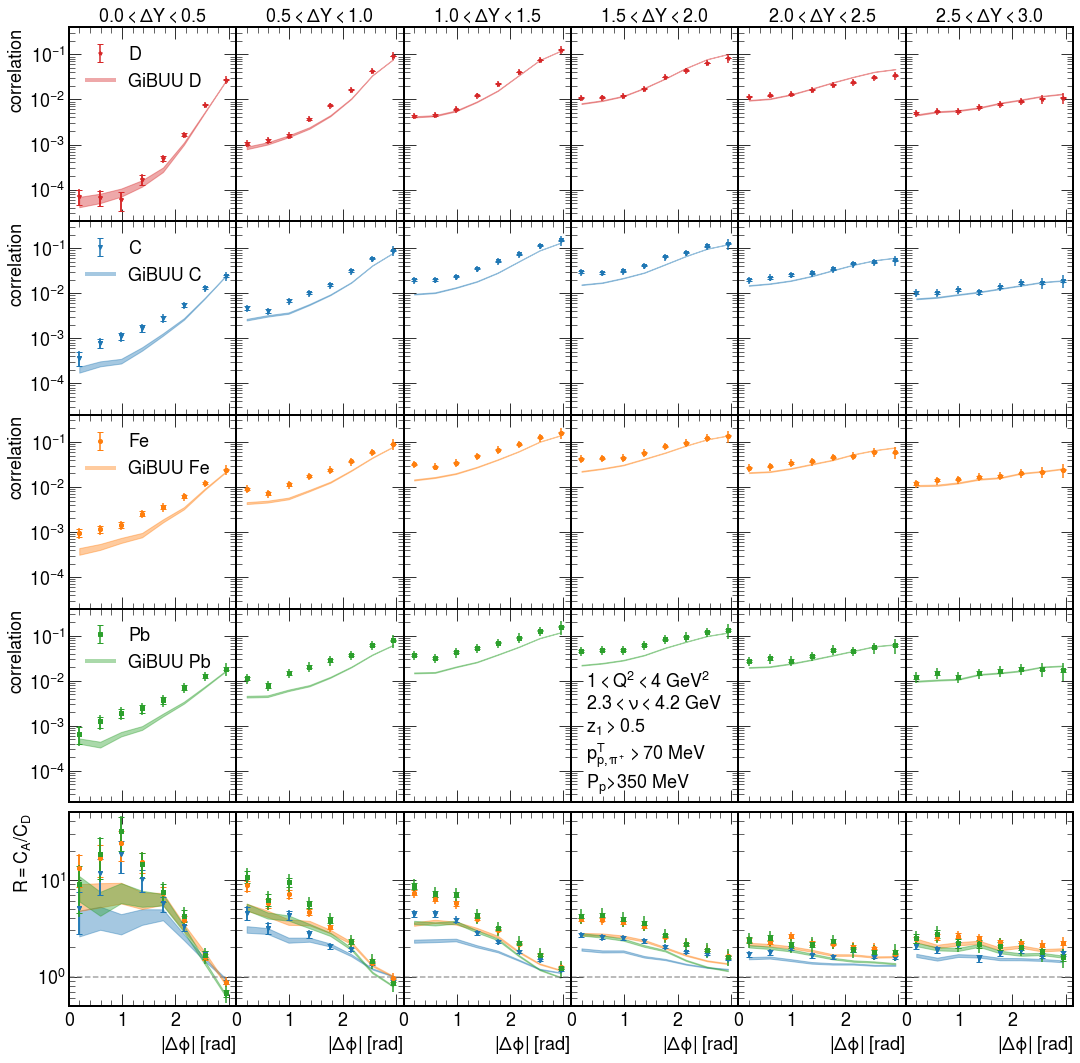

In [35]:
arg=dict( legend_panel=4)
make_plots_new(normalize(data_corr, 2), normalize(pred_GiBUU['dY'],2), sliceinfo, filename_tag='dY_GiBUU', **arg,ymax=(0.4, 50),
              prediction_name="GiBUU")

/tmp/ipykernel_630122/4141525760.py:180: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i][j].set_xticklabels(["0", "0", "1", "2", ""])


saving to /home/sebouh/Documents/Overleaf_git/PionProtonAN/figures/results/main//corr_dY_GiBUU_notlog.pdf


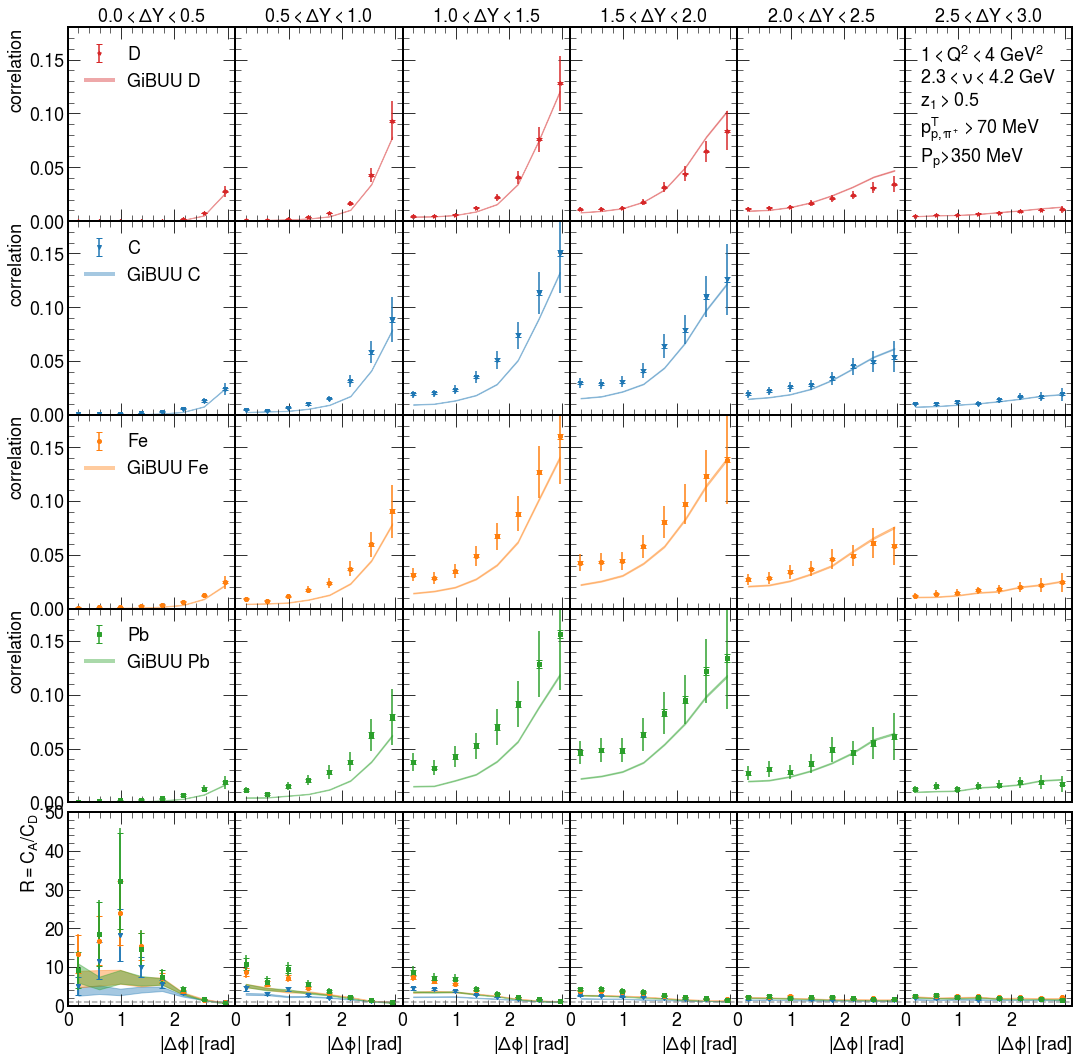

In [465]:
make_plots_new(normalize(data_corr, 2), normalize(pred_GiBUU['dY'],2), sliceinfo, filename_tag='dY_GiBUU_notlog', **arg,ymax=(0.18, 50),
              prediction_name="GiBUU", logC=False)
#make_plots_new(normalize(data_corr, 2), normalize(pred_GiBUU['dY'],2), sliceinfo, filename_tag='dY_GiBUU', **arg,ymax=(0.16, 40),
#              prediction_name="GiBUU", logC=False)

/tmp/ipykernel_630122/2941605711.py:180: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i][j].set_xticklabels(["0", "0", "1", "2", ""])


saving to /home/sebouh/Documents/Overleaf_git/PionProtonAN/figures/results/main//corr_dY_BeAGLE.pdf


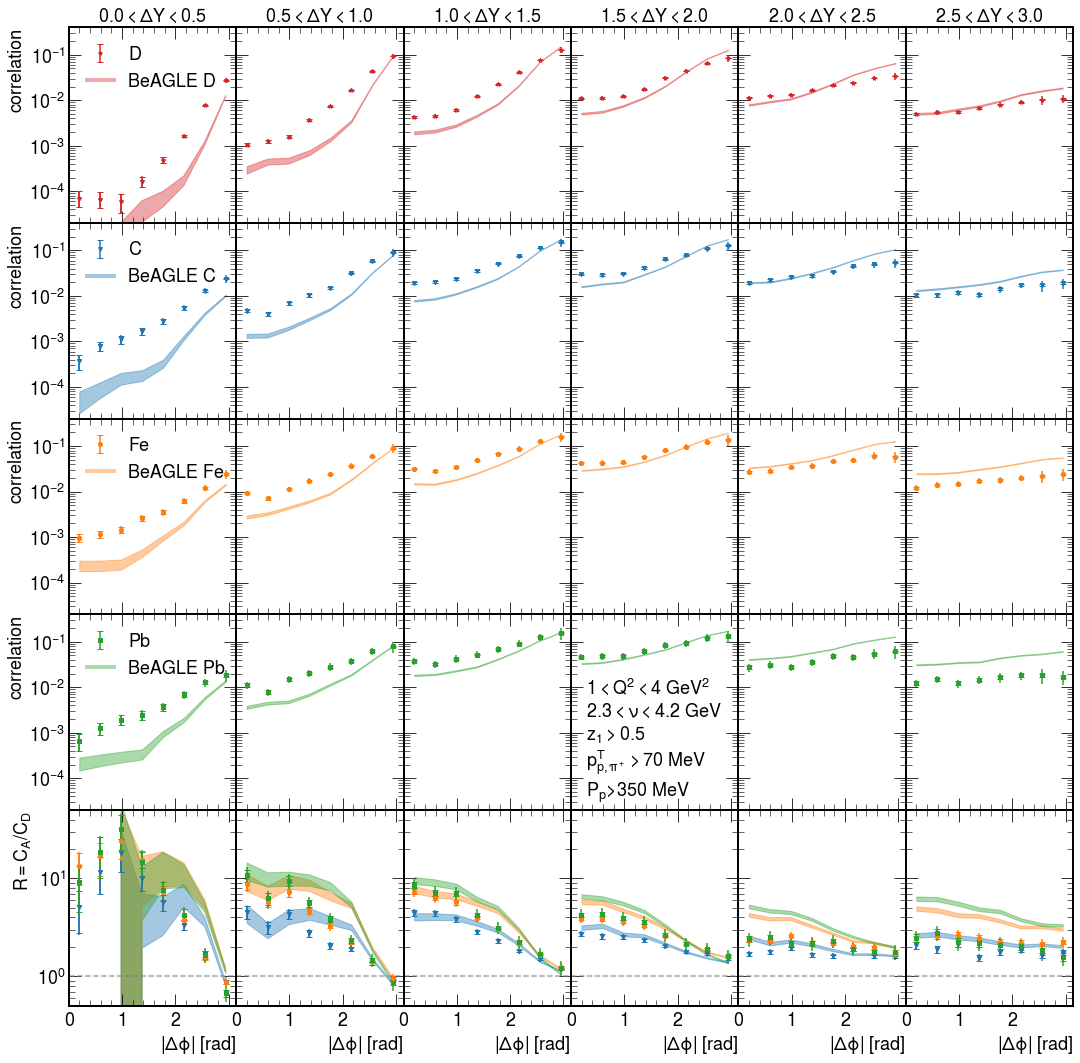

In [314]:
make_plots_new(normalize(data_corr, 2), normalize(pred_BeAGLE[1]['dY'],2), sliceinfo, filename_tag='dY_BeAGLE', **arg,ymax=(0.4, 50),
              prediction_name="BeAGLE")
# make_plots_new(normalize(data_corr, 2), normalize(pred_BeAGLE_100['dY'],2), sliceinfo, filename_tag='dY_BeAGLE', **arg,ymax=(0.4, 50),
#               prediction_name="BeAGLE")

In [130]:
# for i in 4,5:
#     C=all_data['dY'][i]['Pb']['C']
#     dphi=all_data['dY'][i]['Pb']['phi']
#     dCstat=all_data['dY'][i]['Pb']['dCstat']
#     dCsyst=all_data['dY'][i]['Pb']['dCsyst']
#     plt.errorbar(dphi, C, np.hypot(dCstat,dCsyst), color='tab:green', ls='', marker='o')
#     plt.errorbar(dphi, C, dCstat,capsize=5, color='tab:green', ls='', marker='o')
#     plt.xlabel("$|\\Delta\\phi|$ [rad]")
#     plt.ylabel("correlation")
#     plt.title(f"Pb, {1.0+.5*(i-4):.1f}<$\\Delta\\phi$<{1.5+.5*(i-4):.1f}")
#     plt.show()

In [466]:
table=""
for i in range(6):
    for j in range(8):
        dycuts=f"{0.5*i:.1f}$-${0.5+0.5*i:.1f}" if j == 0 else ""
        line=f"{dycuts} & {j*np.pi/8:.2f}$-${(j+1)*np.pi/8:.2f}"
        
        for A in "D C Fe Pb".split():
            C=all_data['dY'][i][A].C[j]
            stat=all_data['dY'][i][A].dCstat[j]
            syst=all_data['dY'][i][A].dCsyst[j]
            for pow in 1, 2,3,4,5:
                if C>0.1**pow:
                    #line = line+f"&$({C*10**pow:.2f}\\pm{stat*10**pow:.2f}\\pm{syst*10**pow:.2f})e-{pow}$"
                    line = line+f"&${C*10**pow:.2f}({stat*10**pow*100:.0f})({syst*10**pow*100:.0f})\\times 10^{{{-pow}}}$"
                    
                    break
        line+="\\\\\n"
        table+=line
    table+="\\hline\n"
    if i %3==2:
        !mkdir tables_pion_proton
        with open(f"tables_pion_proton/correlations_{i//3+1}.txt", 'w') as f:
            print(table, file=f)
            print(table)
        table=''

        

mkdir: cannot create directory ‘tables_pion_proton’: File exists
0.0$-$0.5 & 0.00$-$0.39&$7.23(269)(132)\times 10^{-5}$&$3.72(131)(60)\times 10^{-4}$&$9.65(193)(173)\times 10^{-4}$&$6.60(269)(146)\times 10^{-4}$\\
 & 0.39$-$0.79&$6.81(256)(112)\times 10^{-5}$&$7.95(180)(128)\times 10^{-4}$&$1.15(20)(21)\times 10^{-3}$&$1.26(35)(28)\times 10^{-3}$\\
 & 0.79$-$1.18&$6.08(269)(102)\times 10^{-5}$&$1.12(22)(18)\times 10^{-3}$&$1.45(23)(26)\times 10^{-3}$&$1.96(45)(43)\times 10^{-3}$\\
 & 1.18$-$1.57&$1.68(42)(28)\times 10^{-4}$&$1.69(28)(27)\times 10^{-3}$&$2.58(31)(46)\times 10^{-3}$&$2.45(52)(54)\times 10^{-3}$\\
 & 1.57$-$1.96&$4.91(67)(74)\times 10^{-4}$&$2.80(36)(47)\times 10^{-3}$&$3.55(37)(67)\times 10^{-3}$&$3.71(63)(87)\times 10^{-3}$\\
 & 1.96$-$2.36&$1.64(12)(24)\times 10^{-3}$&$5.50(50)(89)\times 10^{-3}$&$6.25(49)(114)\times 10^{-3}$&$7.01(87)(157)\times 10^{-3}$\\
 & 2.36$-$2.75&$7.67(25)(114)\times 10^{-3}$&$1.31(8)(21)\times 10^{-2}$&$1.22(7)(22)\times 10^{-2}$&$1.28(12)(29

In [467]:
table=""
for i in range(6):
    for j in range(8):
        dycuts=f"{0.5*i:.1f}$-${0.5+0.5*i:.1f}" if j == 0 else ""
        line=f"{dycuts} & {j*np.pi/8:.2f}$-${(j+1)*np.pi/8:.2f}"
        
        for A in "C Fe Pb".split():
            R=all_data['dY'][i][A].R[j]
            stat=all_data['dY'][i][A].dRstat[j]
            syst=all_data['dY'][i][A].dRsyst[j]
            line = line+f"&${R:.2f}\\pm{stat:.2f}\\pm{syst:.2f}$"
        line+="\\\\\n"
        table+=line
    table+="\\hline\n"
    if i %3==2:
        !mkdir tables_pion_proton
        with open(f"tables_pion_proton/ratios_{i//3+1}.txt", 'w') as f:
            print(table, file=f)
            print(table)
        table=''

mkdir: cannot create directory ‘tables_pion_proton’: File exists
0.0$-$0.5 & 0.00$-$0.39&$5.14\pm2.39\pm0.62$&$13.34\pm4.83\pm1.94$&$9.13\pm4.63\pm1.77$\\
 & 0.39$-$0.79&$11.68\pm4.77\pm1.08$&$16.83\pm6.26\pm2.06$&$18.45\pm8.25\pm3.28$\\
 & 0.79$-$1.18&$18.36\pm6.73\pm1.80$&$23.89\pm8.23\pm3.03$&$32.16\pm12.44\pm5.80$\\
 & 1.18$-$1.57&$10.09\pm2.57\pm0.91$&$15.38\pm3.51\pm1.86$&$14.61\pm4.20\pm2.58$\\
 & 1.57$-$1.96&$5.70\pm1.01\pm0.36$&$7.22\pm1.16\pm0.75$&$7.55\pm1.60\pm1.26$\\
 & 1.96$-$2.36&$3.35\pm0.38\pm0.20$&$3.81\pm0.40\pm0.38$&$4.28\pm0.61\pm0.70$\\
 & 2.36$-$2.75&$1.70\pm0.12\pm0.10$&$1.59\pm0.10\pm0.16$&$1.67\pm0.17\pm0.27$\\
 & 2.75$-$3.14&$0.87\pm0.04\pm0.06$&$0.88\pm0.04\pm0.10$&$0.67\pm0.05\pm0.12$\\
\hline
0.5$-$1.0 & 0.00$-$0.39&$4.54\pm0.67\pm0.36$&$8.73\pm1.06\pm0.99$&$10.75\pm1.60\pm1.84$\\
 & 0.39$-$0.79&$3.17\pm0.44\pm0.21$&$5.73\pm0.63\pm0.60$&$6.25\pm0.92\pm1.04$\\
 & 0.79$-$1.18&$4.30\pm0.47\pm0.30$&$7.20\pm0.66\pm0.77$&$9.46\pm1.06\pm1.58$\\
 & 1.18$-$1.57&$2.

In [36]:
import pickle
with open("pion_proton_results.pkl", "wb") as f:
    pickle.dump(all_data, f, pickle.HIGHEST_PROTOCOL)

In [37]:
results={"data":all_data, "BeAGLE":pred_BeAGLE[1], "GiBUU":pred_GiBUU}

In [38]:
vals=np.array([])
for i in range(6):
    vals=np.concatenate([vals, np.abs(1-results['GiBUU']['dY'][i]['D'].C/results['data']['dY'][i]['D'].C)])
print(np.max(vals))
print(np.sqrt(np.mean(vals**2)))
print(np.median(vals))

vals=np.array([])
for A in "Pb".split():
    for i in range(6):
        vals=np.concatenate([vals, results['GiBUU']['dY'][i][A].C/results['data']['dY'][i][A].C])
print(np.min(vals),np.max(vals))
print(np.mean(vals))

0.4398986918504797
0.21440836560781312
0.15628406609586087
0.3075365456026104 1.245734385540063
0.6719808588661526


In [39]:
width_broadening_data={}

b= [-0.68613088  0.          0.50115673  0.60734655]
(2, 12, 56, 208) [-0.68613088  0.          0.50115673  0.60734655] [0.00989021 0.         0.01617095 0.0181232 ] [0.030971345202201614, 0.0, 0.019771705253013284, 0.025750393935658856]
b= [-0.54198984  0.          0.442668    0.54652843]
b= [-0.69981571  0.          0.56620349  0.73323089]
[0.029118126563985738, 0.028179439027989136, 0.030971345202201614, 0.02439162091971837, 0.014417534374159746, 0.021529188214458476]
[0.020564033783219134, 0.024387594539084644, 0.019771705253013284, 0.01850947485603987, 0.014632595071432827, 0.054476880997711835]
[0.022153553164460084, 0.02944683060840708, 0.025750393935658856, 0.023988541990320456, 0.023311440116238886, 0.01932201849543437]


/tmp/ipykernel_1651609/2906341653.py:58: RuntimeWarning: divide by zero encountered in divide
  db=np.hypot(sigmas_dPhi[res_set]*dsigmas_dPhi_stat[res_set],sigmas_dPhi[res_set][1]*dsigmas_dPhi_stat[res_set][1])/np.abs(b)
/tmp/ipykernel_1651609/2906341653.py:58: RuntimeWarning: divide by zero encountered in divide
  db=np.hypot(sigmas_dPhi[res_set]*dsigmas_dPhi_stat[res_set],sigmas_dPhi[res_set][1]*dsigmas_dPhi_stat[res_set][1])/np.abs(b)


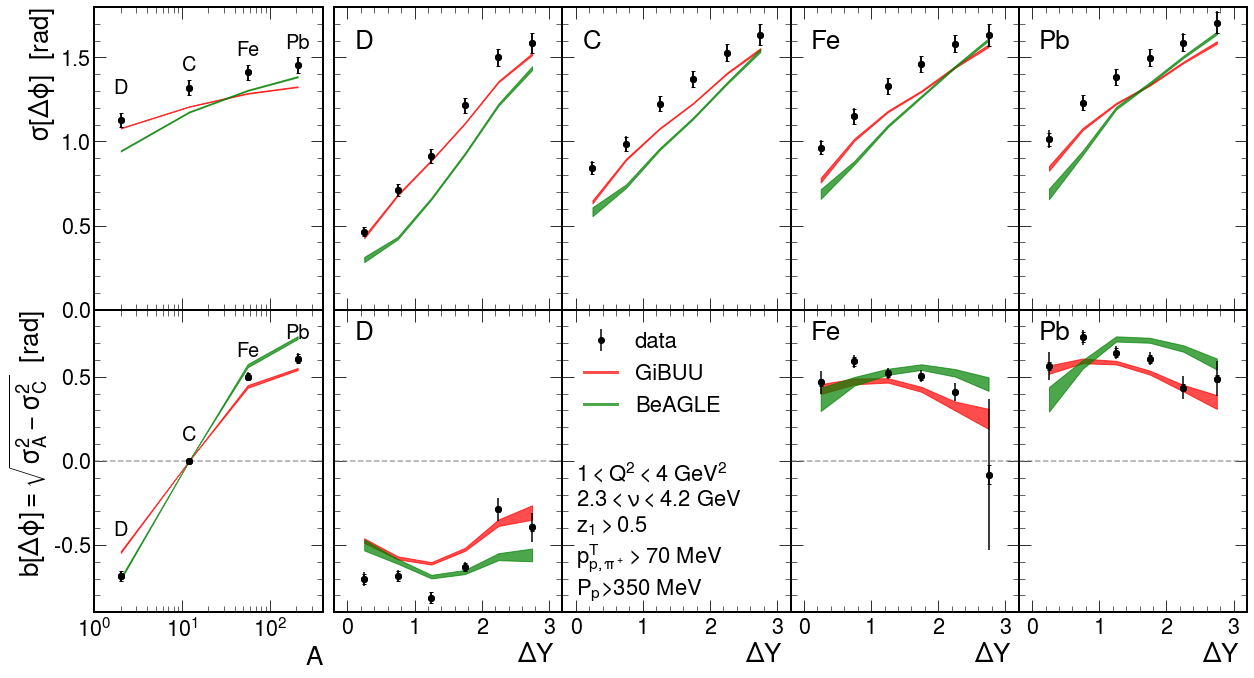

In [41]:

MCs=["GiBUU", "BeAGLE"]

lbl_args=dict(fontsize=20, ha='center')
fig,axs=plt.subplots(2,6, figsize=(18,10), 
                     sharex='col', sharey='row', gridspec_kw=dict(width_ratios=(1,0.05, 1,1,1,1)))
axs[0][1].axis('off')
axs[1][1].axis('off')

colors={"GiBUU":"r", "BeAGLE":"g"}
#colors='tab:red tab:blue tab:orange tab:green'.split()

plt.sca(axs[0][0])
x=(2,12,56, 208)
plt.ylabel("$\\sigma[\Delta\phi]$  [rad]")
plt.xlabel("A")
plt.xscale('log')
plt.xlim(1, 4e2)
#plt.ylim(0.5, 1.7)
sigmas_dPhi={}
dsigmas_dPhi_stat={}
dsigmas_dPhi_tot={}
dsigmas_dPhi_syst={}
for res_set in ["data"]+MCs:
    sigmas_dPhi[res_set]=[]
    dsigmas_dPhi_stat[res_set]=[]
    dsigmas_dPhi_syst[res_set]=[]
    dsigmas_dPhi_tot[res_set]=[]
    for i, A in enumerate("D C Fe Pb".split()):
        sigma=np.sqrt(sum(np.concatenate([results[res_set]['dY'][j][A].eval(f"C*(phi-{np.pi})**2") for j in range(6)]))/\
                     sum(np.concatenate([results[res_set]['dY'][j][A].C for j in range(6)])))
        sigmas_dPhi[res_set].append(sigma)
        C=np.concatenate([results[res_set]['dY'][j][A].C for j in range(6)])
        dCstat=np.concatenate([results[res_set]['dY'][j][A].dCstat for j in range(6)])
        bin_centers=np.concatenate([results[res_set]['dY'][j][A].phi for j in range(6)])
        dsigma=np.sqrt(sum(dCstat**2*(((bin_centers-np.pi)**2-sigma**2)/sum(C))**2))/(2*sigma)
        dsigmas_dPhi_stat[res_set].append(dsigma)
        if res_set=="data":
            refbin=2 #use the systematic uncertainty from the 3rd deltaY* bin
            syst=results[res_set]['dY'][refbin][A+"_dwidth_syst"]
            dsigmas_dPhi_syst[res_set].append(syst)
            dsigmas_dPhi_tot[res_set].append(np.hypot(dsigma, syst))
        if res_set=="data":
            width_broadening_data[(A,"unbinned")]={"sigma":sigma,"dsigma_stat":dsigma,"dsigma_syst": syst}
    sigmas_dPhi[res_set]=np.array(sigmas_dPhi[res_set])
    if res_set=="data":
        plt.errorbar(x,sigmas_dPhi[res_set], dsigmas_dPhi_syst[res_set], color='k', ls='', marker='o', capsize=2)
        #print(sigmas_dPhi[res_set], dsigmas_dPhi_tot[res_set])
        plt.errorbar(x,sigmas_dPhi[res_set], dsigmas_dPhi_tot[res_set], color='k', ls='', marker='o', capsize=0)
        for i,a in enumerate("D C Fe Pb".split()):
            plt.text(x[i],sigmas_dPhi[res_set][i]+.1+(.06 if a=='D' else 0), a, **lbl_args)
    else:
        plt.fill_between(x,sigmas_dPhi[res_set]- dsigmas_dPhi_stat[res_set],sigmas_dPhi[res_set]+ dsigmas_dPhi_stat[res_set], color=colors[res_set], ls='-', alpha=0.7)
    
plt.sca(axs[1][0])
for res_set in ["data"]+MCs:
    b=signed_sqrt(np.array(sigmas_dPhi[res_set])**2-sigmas_dPhi[res_set][1]**2)
    print('b=',b)
    db=np.hypot(sigmas_dPhi[res_set]*dsigmas_dPhi_stat[res_set],sigmas_dPhi[res_set][1]*dsigmas_dPhi_stat[res_set][1])/np.abs(b)
    db[1]=0
    refbin=2
    if res_set=="data":
        db_syst=[results[res_set]['dY'][refbin][["D","C","Fe","Pb"][i]+"_dbroad_syst"] for i in range(4)]
        for i, A in enumerate("D C Fe Pb".split()):
            width_broadening_data[(A,"unbinned")].update({"b":b[i],"db_stat":db[i],"db_syst":db_syst[i]})
        #print(db_syst)
        #print(x[1:],b, db_syst)
    if res_set=="data":
        print(x, b, db, db_syst)
        plt.errorbar(x,b,db, color='k', ls='', marker='o', label='data')
        plt.errorbar(x,b,db_syst, color='k', ls='', marker='o', capsize=2)
        plt.errorbar(x,b,np.hypot(db,db_syst), color='k', ls='', marker='o', capsize=0)
        for i,a in enumerate("D C Fe Pb".split()):
            plt.text(x[i],b[i]+.12+.12*(i==0), a, lbl_args)
    else:
        plt.fill_between(x,b-db, b+db, color=colors[res_set], ls='-', alpha=0.7)
axs[1][0].set_xlabel("A")
plt.xlim(*axs[0][0].get_xlim())
plt.xscale("log")

#in bins of Delta Y
for res_set in ["data"]+MCs:
    
    sigmas_dPhi={}
    dsigmas_dPhi_stat={}
    dsigmas_dPhi_syst={}
    dsigmas_dPhi_tot={}
    for A,i in (("C", 1), ("D", 0), ("Fe", 2), ("Pb",3)):
        expr = f'{np.pi}-dphi'
        #expr = 'drap-0.5*log((nu+sqrt(Q2+nu*nu))/(nu-sqrt(Q2+nu*nu)))'
        Dybins=np.linspace(0.0, 3.0, 7)
        sigmas_dPhi[A]=[]
        dsigmas_dPhi_syst[A]=[]
        dsigmas_dPhi_stat[A]=[]
        dsigmas_dPhi_tot[A]=[]
        for j in range(len(Dybins)-1):
            sigma=np.sqrt(sum(results[res_set]['dY'][j][A].eval(f"C*(phi-{np.pi})**2"))/\
                         sum(results[res_set]['dY'][j][A].C))
            sigmas_dPhi[A].append(sigma)
            C=results[res_set]['dY'][j][A].C
            dCstat=results[res_set]['dY'][j][A].dCstat
            #print("dCstat",dCstat)
            bin_centers=results[res_set]['dY'][j][A].phi
            #print('bin_centers', bin_centers)
            dsigma=np.sqrt(sum(dCstat**2*(((bin_centers-np.pi)**2-sigma**2)/sum(C))**2))/(2*sigma)
            dsigmas_dPhi_stat[A].append(dsigma)
            
            if res_set=="data":
                dsigmas_dPhi_syst[A].append(results[res_set]['dY'][j][A+"_dwidth_syst"])
                width_broadening_data[(A,j)]={"sigma":sigma,"dsigma_stat":dsigma, "dsigma_syst":results[res_set]['dY'][j][A+"_dwidth_syst"]}                       
        sigmas_dPhi[A]=np.array(sigmas_dPhi[A])
        #print('dsigmas',dsigmas_dPhi[A])
            #a=dfs_pair[A].query(q + f' and drap-ycm>{Dybins[j]} and drap-ycm<{Dybins[j+1]}').eval(expr)
            #x.append((Dybins[j]+Dybins[j+1])/2)
            #y.append(np.sqrt(np.mean(a**2)))
            #dy.append(np.std(a**2)/np.sqrt(len(a))/(2*y[-1]))
        plt.sca(axs[0][i+2])
        plt.ylim(0.0, 1.8)
        if res_set=='data':
            plt.text(0.1, 1.55, A)
        x=(Dybins[1:]+Dybins[:-1])/2
        if res_set=='data':
            plt.errorbar(x,sigmas_dPhi[A],dsigmas_dPhi_syst[A], color='k', ls='', marker='o',capsize=2)
            plt.errorbar(x,sigmas_dPhi[A],np.hypot(dsigmas_dPhi_stat[A],dsigmas_dPhi_syst[A]), color='k', ls='', marker='o')
            #print(dsigmas_dPhi_syst[A])
        else:
            plt.fill_between(x,sigmas_dPhi[A]-dsigmas_dPhi_stat[A],sigmas_dPhi[A]+dsigmas_dPhi_stat[A], color=colors[res_set], alpha=0.7)
        
        plt.xlim(-0.2, 3.2)
        plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
        #if i ==0:
        #    y_D=np.array(sigmas_dPhi[A])
        #    dy_d=np.array(dsigmas_dPhi[A])
        #else:
        if i!=1:
            plt.sca(axs[1][i+2])
            plt.ylim(-.5, 1.4)
            plt.xlim(-0.2, 3.2)
            plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
            if res_set=='data':
                plt.text(0.1, 0.72, A)
            
            
            b=sigmas_dPhi[A]**2-sigmas_dPhi['C']**2
            b=b/np.sqrt(np.abs(b))
            db=np.hypot(dsigmas_dPhi_stat[A]*sigmas_dPhi[A],dsigmas_dPhi_stat['C']*sigmas_dPhi['C'])/np.abs(b)
            if res_set=="data":
                db_syst=[results[res_set]['dY'][j][A+"_dbroad_syst"] for j in range(6)]
                print(db_syst)
                for j in range(len(b)):
                    width_broadening_data[(A,j)].update({"b":b[j],"db_stat":db[j],"db_syst":db_syst[j]})
            if res_set=='data':
                plt.errorbar(x,b,db_syst, color='k', ls='', marker='o', capsize=2)
                plt.errorbar(x,b,np.hypot(db_syst, db), color='k', ls='', marker='o')
            else:
                plt.fill_between(x,b-db, b+db, color=colors[res_set], alpha=0.7)
            
for i in range(4):
    axs[1][i+2].set_xlabel("$\\Delta Y$  ")
#    axs[0][i+2].axvline(0, ls='--', alpha=0.7, color='0.5')

for i in range(4):
    if i !=1:
        axs[1][i+2].axhline(0, ls='--', alpha=0.7, color='0.5')
#    axs[1][i+2].axvline(0, ls='--', alpha=0.7, color='0.5')
axs[1][0].axhline(0, ls='--', alpha=0.7, color='0.5')
    
axs[0][0].set_ylabel("$\\sigma[\\Delta\\phi]$  [rad]")
axs[1][0].set_ylabel("$b[\\Delta\\phi]=\\sqrt{\\sigma_A^2-\\sigma^2_C}$  [rad]")

#now make the legend in the empty panel
plt.sca(axs[1][3])
#plt.ylim(-.5, 1.4)
plt.ylim(-0.9, 0.9)
plt.xlim(-0.2, 3.2)
plt.errorbar([],[],[], color='k', ls='', marker='o', label='data')
for res_set in MCs:
    plt.errorbar([],[], color=colors[res_set], label=res_set, ls='-', lw='3', alpha=0.7)
plt.legend(fontsize=22, loc='upper left')
cuts_txt="$1<Q^2<4$ GeV$^2$\n"+\
                      "$2.3<\\nu<4.2$ GeV\n"+\
                      "$z_1>0.5$\n"+\
                      "$p_{p,\pi^+}^T>70$ MeV\n"+\
                      "$P_p$>350 MeV"
plt.text(0,-.8, cuts_txt, fontsize=22)

# #add data from pi+pi- dataset

# #1.110$\pm$0.005$\pm$0.030& 1.234$\pm$0.008$\pm$0.034& 1.279$\pm$0.008$\pm$0.036& 1.304$\pm$0.013$\pm$0.037
# from io import StringIO

# csv_string = """
# A,deltaY,sigma,dsigmastat,dsigmasyst
# 2,unbinned,1.110,0.005,0.030
# 12,unbinned,1.234,0.008,0.034
# 56,unbinned,1.279,0.008,0.036
# 208,unbinned,1.304,0.013,0.037
# """

# pippim = pd.read_csv(StringIO(csv_string))
# q="deltaY=='unbinned'"
# axs[0][0].errorbar(pippim.query(q).A, pippim.query(q).sigma, pippim.query(q).eval("sqrt(dsigmastat**2+dsigmasyst**2)"), color='#77777777', 
#                   marker='s', ls='', fillstyle='none')






plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("images/pi_p_widths_broadenings.pdf")
plt.show()

In [471]:
table=""
for row in "unbinned",0,1,2,3,4,5:
    if row=="unbinned":
        dycuts=f"{0:.1f}$-${3.0:.1f}"
    else:
        dycuts=f"{0.5*row:.1f}$-${0.5+0.5*row:.1f}"
    line=f"{dycuts} "
    
    for A in "D C Fe Pb".split():
        s=width_broadening_data[(A, row)]['sigma']
        stat=width_broadening_data[(A, row)]['dsigma_stat']
        syst=width_broadening_data[(A, row)]['dsigma_syst']
        line = line+f"&${s:.3f}\\pm{stat:.3f}\\pm{syst:.3f}$"
    line+="\\\\\n"
    table+=line
    if row=="unbinned":
        table+="\\hline\n"
table+="\\hline\n"
!mkdir tables_pion_proton
with open(f"tables_pion_proton/widths.txt", 'w') as f:
    print(table, file=f)
    print(table)
table=''

mkdir: cannot create directory ‘tables_pion_proton’: File exists
0.0$-$3.0 &$1.126\pm0.003\pm0.040$&$1.319\pm0.005\pm0.044$&$1.411\pm0.004\pm0.046$&$1.452\pm0.006\pm0.048$\\
\hline
0.0$-$0.5 &$0.464\pm0.011\pm0.028$&$0.841\pm0.025\pm0.035$&$0.962\pm0.024\pm0.039$&$1.013\pm0.039\pm0.038$\\
0.5$-$1.0 &$0.710\pm0.005\pm0.036$&$0.987\pm0.012\pm0.041$&$1.150\pm0.010\pm0.045$&$1.230\pm0.017\pm0.046$\\
1.0$-$1.5 &$0.915\pm0.004\pm0.040$&$1.224\pm0.008\pm0.044$&$1.330\pm0.007\pm0.046$&$1.383\pm0.011\pm0.048$\\
1.5$-$2.0 &$1.215\pm0.005\pm0.045$&$1.369\pm0.008\pm0.047$&$1.459\pm0.007\pm0.048$&$1.498\pm0.011\pm0.049$\\
2.0$-$2.5 &$1.500\pm0.006\pm0.049$&$1.527\pm0.011\pm0.049$&$1.582\pm0.009\pm0.050$&$1.589\pm0.015\pm0.052$\\
2.5$-$3.0 &$1.587\pm0.010\pm0.059$&$1.635\pm0.017\pm0.061$&$1.633\pm0.014\pm0.063$&$1.707\pm0.024\pm0.062$\\
\hline



In [472]:
table=""
for row in "unbinned",0,1,2,3,4,5:
    if row=="unbinned":
        dycuts=f"{0:.1f}$-${3.0:.1f}"
    else:
        dycuts=f"{0+0.5*row:.1f}$-${0.5+0.5*row:.1f}"
    line=f"{dycuts} "
    
    for A in "D Fe Pb".split():
        #print(A, row, width_broadening_data[(A, row)])
        b=width_broadening_data[(A, row)]['b']
        stat=width_broadening_data[(A, row)]['db_stat']
        syst=width_broadening_data[(A, row)]['db_syst']
        line = line+f"&${b:.3f}\\pm{stat:.3f}\\pm{syst:.3f}$"
    line+="\\\\\n"
    table+=line
    if row=="unbinned":
        table+="\\hline\n"
table+="\\hline\n"
with open(f"tables_pion_proton/broadenings.txt", 'w') as f:
    print(table, file=f)
    print(table)
table=''

0.0$-$3.0 &$-0.686\pm0.010\pm0.031$&$0.501\pm0.016\pm0.020$&$0.607\pm0.018\pm0.026$\\
\hline
0.0$-$0.5 &$-0.701\pm0.030\pm0.029$&$0.468\pm0.066\pm0.021$&$0.565\pm0.079\pm0.022$\\
0.5$-$1.0 &$-0.685\pm0.018\pm0.028$&$0.591\pm0.028\pm0.024$&$0.735\pm0.032\pm0.029$\\
1.0$-$1.5 &$-0.813\pm0.013\pm0.031$&$0.521\pm0.026\pm0.020$&$0.645\pm0.029\pm0.026$\\
1.5$-$2.0 &$-0.632\pm0.020\pm0.024$&$0.502\pm0.030\pm0.019$&$0.609\pm0.033\pm0.024$\\
2.0$-$2.5 &$-0.287\pm0.066\pm0.014$&$0.410\pm0.053\pm0.015$&$0.436\pm0.067\pm0.023$\\
2.5$-$3.0 &$-0.396\pm0.082\pm0.022$&$-0.081\pm0.445\pm0.054$&$0.490\pm0.102\pm0.019$\\
\hline



In [473]:
for tag in "syst_mix syst_cuts syst_EC syst_pid syst stat tot".split():
    for agroup in ["D"], "C Fe Pb".split():
        maxSyst=0
        minSyst=99
        for a in agroup:
            for i in range(6):
                if tag=='tot':
                    all_data['dY'][i][a].eval('dCtot=sqrt(dCstat**2+dCsyst**2)', inplace=True)
                dCrel=all_data['dY'][i][a].eval(f'dC{tag}/C')
                minSyst=min(minSyst, min(dCrel))
                maxSyst=max(maxSyst, max(dCrel))
        print(tag, agroup, f"{minSyst*100:.1f}-{maxSyst*100:.1f}")
print()
for tag in "syst_mix syst_cuts syst_EC syst_pid syst stat tot".split():
    for agroup in ["C Fe Pb".split()]:
        maxSyst=0
        minSyst=99
        for a in agroup:
            for i in range(6):
                if tag=='tot':
                    all_data['dY'][i][a].eval('dRtot=sqrt(dRstat**2+dRsyst**2)', inplace=True)
                if tag=='syst_cuts':
                    all_data['dY'][i][a].eval('dRsyst_cuts=0', inplace=True)
                dCrel=all_data['dY'][i][a].eval(f'dR{tag}/R')
                minSyst=min(minSyst, min(dCrel))
                maxSyst=max(maxSyst, max(dCrel))
        print(tag, agroup, f"{minSyst*100:.1f}-{maxSyst*100:.1f}")

syst_mix ['D'] 14.9-14.9
syst_mix ['C', 'Fe', 'Pb'] 14.9-14.9
syst_cuts ['D'] 0.0-7.0
syst_cuts ['C', 'Fe', 'Pb'] 0.0-7.0
syst_EC ['D'] 0.0-10.5
syst_EC ['C', 'Fe', 'Pb'] 0.0-0.2
syst_pid ['D'] 0.0-20.8
syst_pid ['C', 'Fe', 'Pb'] 5.9-37.1
syst ['D'] 14.9-26.6
syst ['C', 'Fe', 'Pb'] 16.0-40.6
stat ['D'] 0.8-44.2
stat ['C', 'Fe', 'Pb'] 1.5-40.8
tot ['D'] 15.0-47.3
tot ['C', 'Fe', 'Pb'] 16.6-46.4

syst_mix ['C', 'Fe', 'Pb'] 0.0-0.0
syst_cuts ['C', 'Fe', 'Pb'] 0.0-0.0
syst_EC ['C', 'Fe', 'Pb'] 0.1-10.5
syst_pid ['C', 'Fe', 'Pb'] 5.9-20.6
syst ['C', 'Fe', 'Pb'] 6.0-20.6
stat ['C', 'Fe', 'Pb'] 1.8-50.8
tot ['C', 'Fe', 'Pb'] 6.5-54.3


In [500]:
for tag in "syst_mix syst_cuts syst_EC syst_pid syst_fbw syst stat tot".split():
    for agroup in ["D"], "C Fe Pb".split():
        maxSyst=0
        minSyst=99
        for a in agroup:
            for i in range(6):
                if tag=='tot':
                    all_data['dY'][i][f'{a}_dwidth_tot']=\
                        np.hypot(all_data['dY'][i][f'{a}_dwidth_stat'], all_data['dY'][i][f'{a}_dwidth_syst'])
                dCrel=all_data['dY'][i][f'{a}_dwidth_{tag}']/all_data['dY'][i][f'{a}_width']
                minSyst=min(minSyst, dCrel)
                maxSyst=max(maxSyst, dCrel)
        print(tag, agroup, f"{minSyst*100:.1f}-{maxSyst*100:.1f}")
print()
for tag in "syst_mix syst_cuts syst_EC syst_pid syst_fbw syst stat tot".split():
    for agroup in ["D Fe Pb".split()]:
        maxSyst=0
        minSyst=99
        for a in agroup:
            for i in range(6):
                if tag=='tot':
                    all_data['dY'][i][f'{a}_dbroad_tot']=\
                        np.hypot(all_data['dY'][i][f'{a}_dbroad_stat'], all_data['dY'][i][f'{a}_dbroad_syst'])
                dCrel=all_data['dY'][i][f'{a}_dbroad_{tag}']/all_data['dY'][i][f'{a}_broad']
                minSyst=min(np.abs(minSyst), np.abs(dCrel))
                maxSyst=max(np.abs(maxSyst), np.abs(dCrel))
        print(tag, agroup, f"{minSyst*100:.1f}-{maxSyst*100:.1f}")
# print()
# for tag in "syst_mix syst_cuts syst_EC syst_pid syst stat tot".split():
#     for agroup in ["C Fe Pb".split()]:
#         maxSyst=0
#         minSyst=99
#         for a in agroup:
#             for i in range(6):
#                 if tag=='tot':
#                     all_data['dY'][i][a].eval('dRtot=sqrt(dRstat**2+dRsyst**2)', inplace=True)
#                 dCrel=all_data['dY'][i][a].eval(f'dR{tag}/R')
#                 minSyst=min(minSyst, min(dCrel))
#                 maxSyst=max(maxSyst, max(dCrel))
#         print(tag, agroup, f"{minSyst*100:.1f}-{maxSyst*100:.1f}")

syst_mix ['D'] 2.3-4.3
syst_mix ['C', 'Fe', 'Pb'] 2.3-3.2
syst_cuts ['D'] 0.6-0.6
syst_cuts ['C', 'Fe', 'Pb'] 0.6-0.6
syst_EC ['D'] 0.0-1.0
syst_EC ['C', 'Fe', 'Pb'] 0.0-0.0
syst_pid ['D'] 2.1-3.4
syst_pid ['C', 'Fe', 'Pb'] 2.0-3.0
syst_fbw ['D'] 0.0-2.7
syst_fbw ['C', 'Fe', 'Pb'] 0.0-0.9
syst ['D'] 3.2-6.0
syst ['C', 'Fe', 'Pb'] 3.1-4.2
stat ['D'] 0.4-2.3
stat ['C', 'Fe', 'Pb'] 0.5-4.0
tot ['D'] 3.3-6.4
tot ['C', 'Fe', 'Pb'] 3.2-5.5

syst_mix ['D', 'Fe', 'Pb'] 3.5-3.5
syst_cuts ['D', 'Fe', 'Pb'] 0.0-0.0
syst_EC ['D', 'Fe', 'Pb'] 0.0-2.9
syst_pid ['D', 'Fe', 'Pb'] 0.7-67.1
syst_fbw ['D', 'Fe', 'Pb'] 0.4-3.7
syst ['D', 'Fe', 'Pb'] 3.6-67.1
stat ['D', 'Fe', 'Pb'] 1.8-499.8
tot ['D', 'Fe', 'Pb'] 4.4-504.3


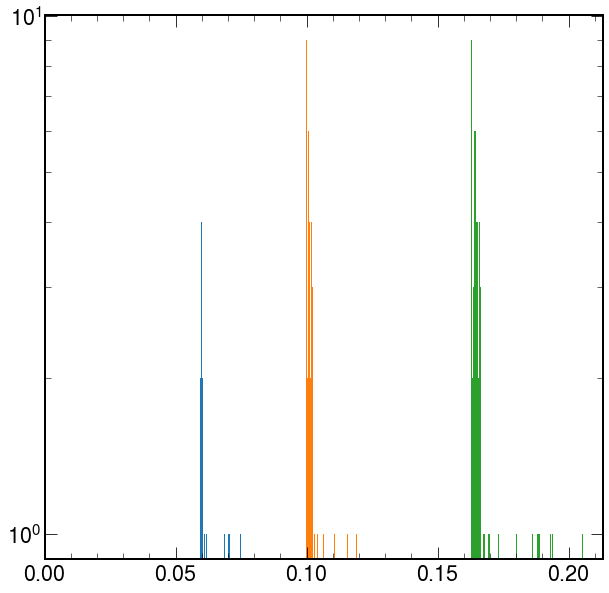

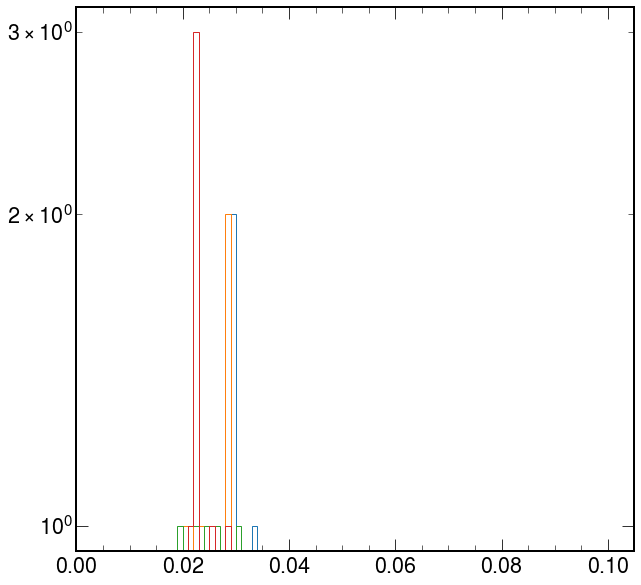

[-0.02232789 -0.02401851 -0.01709203 -0.01278429 -0.02051643 -0.0365087 ]
[ 0.02653234  0.02181094  0.01473905  0.01148372  0.00702998 -0.67055508]
[0.01770168 0.01948396 0.01926461 0.01813917 0.04035529 0.01823436]


(0.0, 0.10500000000000001)

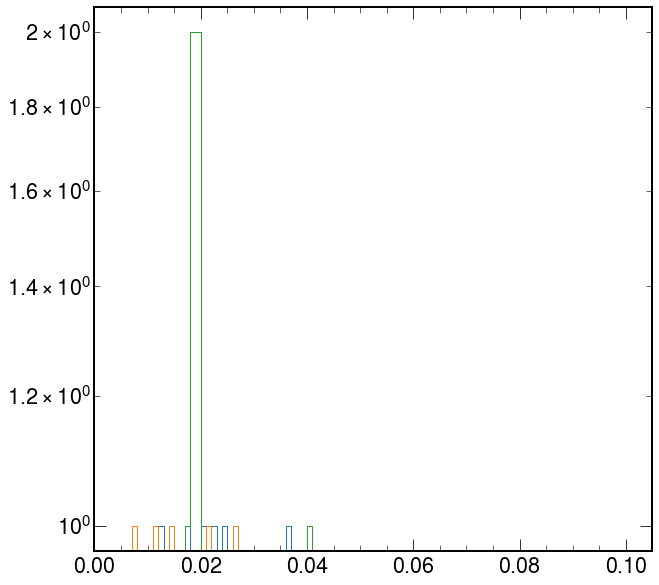

In [503]:
tag="syst_pid"
for a in "C Fe Pb".split():
    dRrel=[]
    for i in range(6):
        dRrel=np.concatenate([dRrel,all_data['dY'][i][a].eval(f'dR{tag}/R')])
    plt.hist(dRrel, bins=100)
plt.yscale("log")
plt.xlim(0)
plt.show()
for a in "D C Fe Pb".split():
    dsrel=[]
    for i in range(6):
        dsrel=np.concatenate([dsrel, [all_data['dY'][i][f'{a}_dwidth_{tag}']/all_data['dY'][i][f'{a}_width']]])
        
    plt.hist(dsrel, bins=100, range=(0, .1), histtype='step')
plt.yscale("log")
plt.xlim(0)
plt.show()
for a in "D Fe Pb".split():
    dbrel=[]
    for i in range(6):
        dbrel=np.concatenate([dbrel,[ all_data['dY'][i][f'{a}_dbroad_{tag}']/all_data['dY'][i][f'{a}_broad']]])
    print(dbrel)
    plt.hist(np.abs(dbrel), bins=100, range=(0, .1), histtype='step')
plt.yscale("log")
plt.xlim(0)

# miscellaneous plots for the analysis note below this line

0    0.196350
1    0.589049
2    0.981748
3    1.374447
4    1.767146
5    2.159845
6    2.552544
7    2.945243
Name: phi, dtype: float64 0    0.969938
1    0.959003
2    0.942227
3    0.959251
4    0.978891
5    0.988412
6    0.994728
7    0.997163
dtype: float64
0    0.196350
1    0.589049
2    0.981748
3    1.374447
4    1.767146
5    2.159845
6    2.552544
7    2.945243
Name: phi, dtype: float64 0    0.979192
1    0.985504
2    0.982030
3    0.988067
4    0.991321
5    0.993204
6    0.995464
7    0.996870
dtype: float64
0    0.196350
1    0.589049
2    0.981748
3    1.374447
4    1.767146
5    2.159845
6    2.552544
7    2.945243
Name: phi, dtype: float64 0    0.981332
1    0.983049
2    0.984418
3    0.988901
4    0.991331
5    0.993484
6    0.994811
7    0.996031
dtype: float64
0    0.196350
1    0.589049
2    0.981748
3    1.374447
4    1.767146
5    2.159845
6    2.552544
7    2.945243
Name: phi, dtype: float64 0    0.989573
1    0.989493
2    0.989910
3    0.990776
4    0.9925

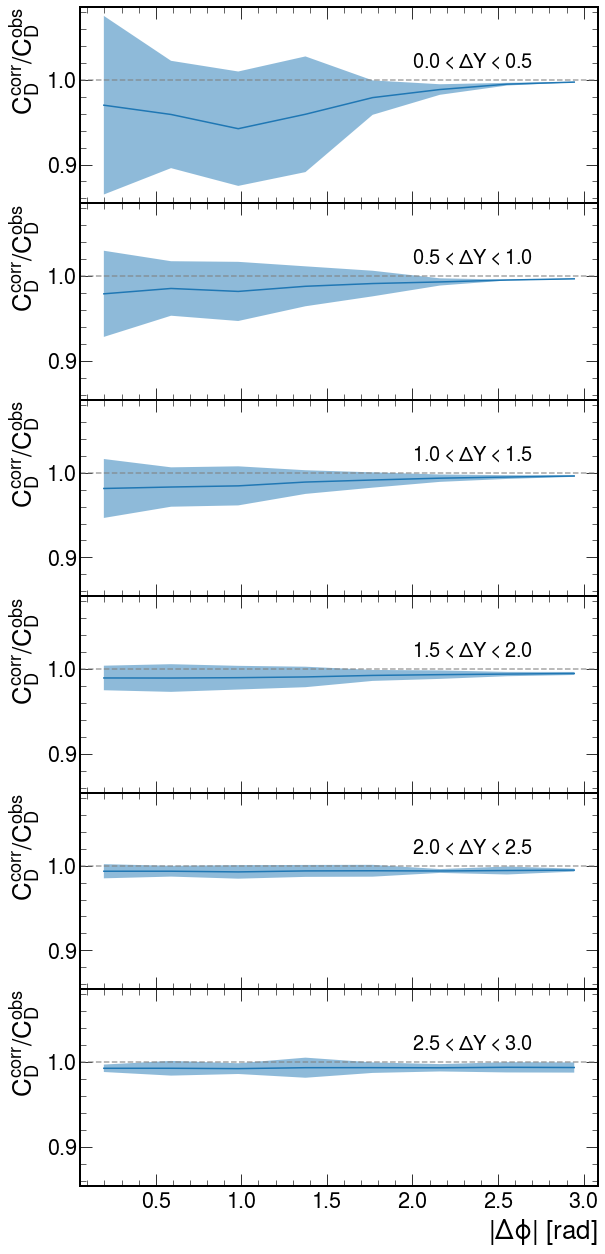

In [68]:
# endcap correction plot
fig, axs = plt.subplots(6, 1, figsize=(9, 18), sharey='all', sharex='all')
(key, nbins) =("dY", 6)
for i in range(nbins):
    plt.sca(axs[i])
    df = all_data[key][i]['D']
    x= df.phi
    dx=x[1]-x[0]
    y = df.C/(df.C-df.C_correction_EC)
    print(x,y)
    dy = df.dCsyst_EC/df.C
    
    
    if key == 'all':
        label = "combined"
    else:
        label = all_sliceinfo[key][i].replace("-", "$-$") + (" GeV" if 'T' in all_sliceinfo[key][i] else "") 
    plt.plot(list(x), list(y))
    
    plt.fill_between(x, y-dy, y+dy, alpha=0.5)
    
    plt.axhline(1., color='0.5', ls='--',alpha=0.7)
    plt.ylabel("$C^{\\rm corr}_D/C^{\\rm obs}_D$")
    plt.text(2.0,1.015, label,fontsize=20)
    #print(yDcorr/yD)
    #print(np.sqrt(np.mean((yDcorr/yD-1)**2)), fAl*np.sqrt(np.mean(((yC-yFe)/yAl/2)**2)))
#plt.legend()
plt.xlabel("$|\Delta\phi|$ [rad]")
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig("corrections_EC.pdf")
plt.show()

In [218]:
for A in "D C Fe Pb".split():
    df=dfs_pair[A]
    df.eval(\
        "mx_eh1h2x_corr2=(nu+.9383-sqrt(h1_p**2+.1396**2)-sqrt(h2_p_corr**2+.9383**2))**2"+\
        "-(-e_px-h1_p*sin(h1_th*3.14159/180)*cos(h1_ph*3.14159/180)-h2_p_corr*sin(h2_th*3.14159/180)*cos(h2_ph*3.14159/180))**2"+\
        "-(-e_py-h1_p*sin(h1_th*3.14159/180)*sin(h1_ph*3.14159/180)-h2_p_corr*sin(h2_th*3.14159/180)*sin(h2_ph*3.14159/180))**2"+\
        "-(5.014-e_pz-h1_p*cos(h1_th*3.14159/180)-h2_p_corr*cos(h2_th*3.14159/180))**2", inplace=True)
    df.eval(\
        "pair_mass_corr=sqrt((sqrt(h1_p**2+.1396**2)+sqrt(h2_p_corr**2+.9383**2))**2"+\
        "-(h1_p*sin(h1_th*3.14159/180)*cos(h1_ph*3.14159/180)+h2_p_corr*sin(h2_th*3.14159/180)*cos(h2_ph*3.14159/180))**2"+\
        "-(h1_p*sin(h1_th*3.14159/180)*sin(h1_ph*3.14159/180)+h2_p_corr*sin(h2_th*3.14159/180)*sin(h2_ph*3.14159/180))**2"+\
        "-(h1_p*cos(h1_th*3.14159/180)+h2_p_corr*cos(h2_th*3.14159/180))**2)",inplace=True)

D frac with negative missing mass 0.3840742356346909
C frac with negative missing mass 0.7116261725136973
Fe frac with negative missing mass 0.7874919103371183
Pb frac with negative missing mass 0.8062458398047482


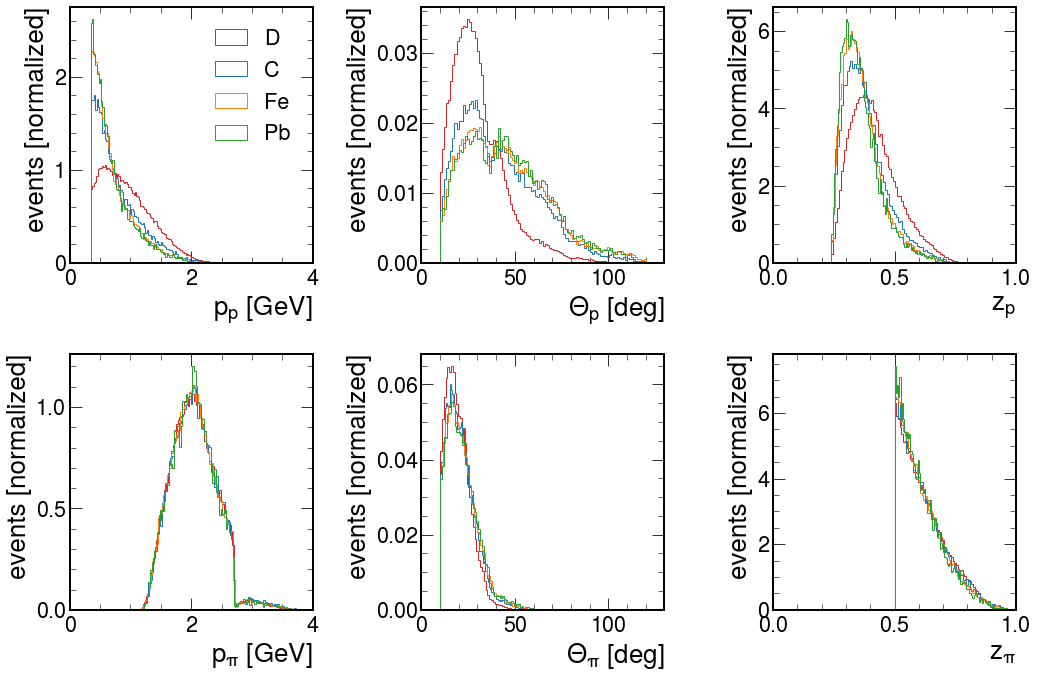

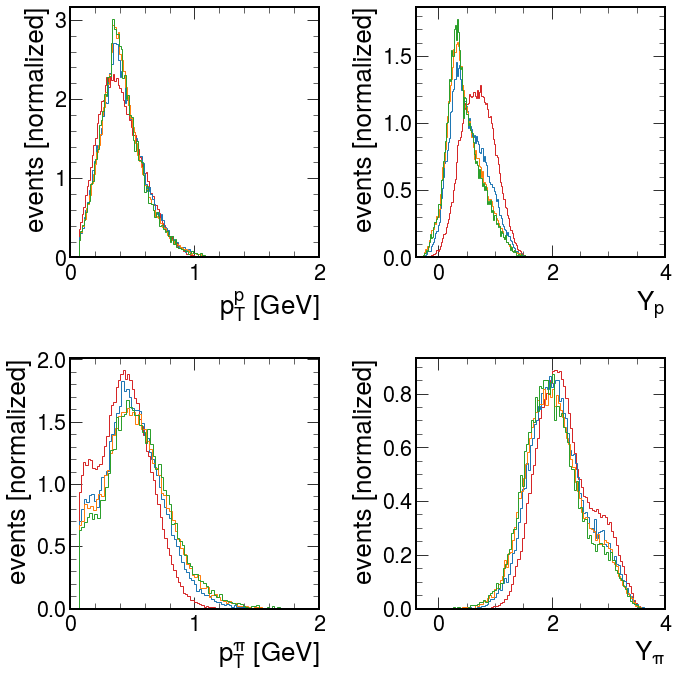

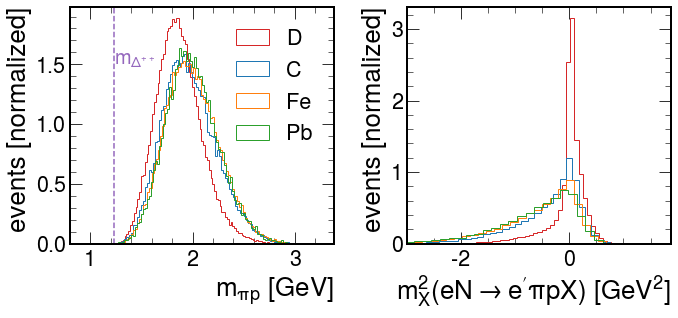

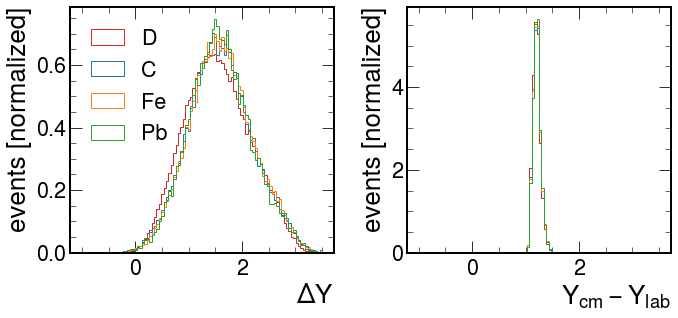

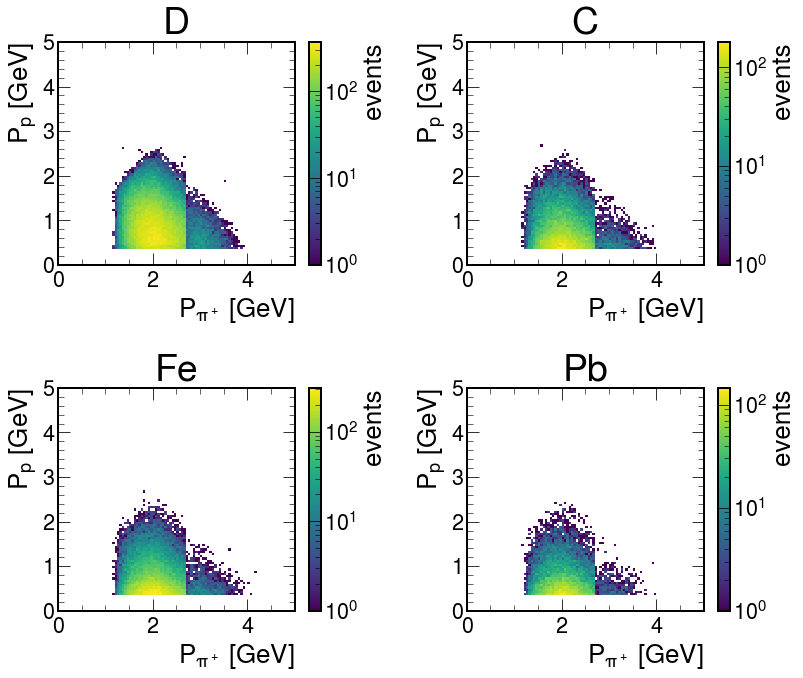

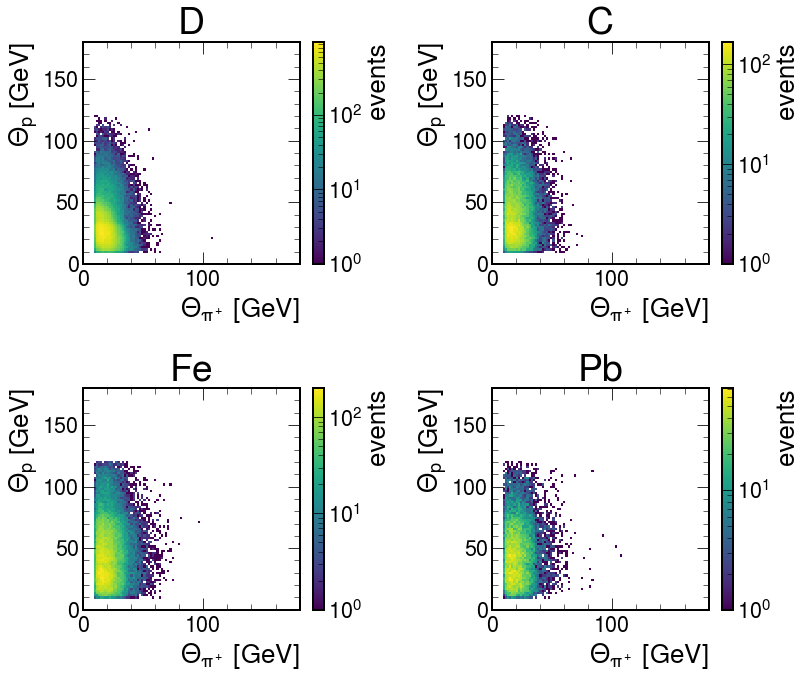

In [235]:
# pT1min=0.07
pT2min=0.07
pMin=0.35

q = f"h1_pid==211   and h1_cm_pt > {pT1min} and "+\
                 f"h2_cm_pt_corr > {pT2min} and h1_z>0.5 and h2_pid==2212 and h2_p_corr>{pMin} and pass_proton_TOF_cut"
colors='tab:red tab:blue tab:orange tab:green k'.split()
fig, axs=plt.subplots(2,3, figsize=(15,10))
plt.sca(axs[0][0])
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'h2_p_corr'
    plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
             color=colors[i], label=A)
plt.xlabel("$p_p$ [GeV]")
plt.ylabel("events [normalized]")
plt.legend(loc='upper right')
plt.xlim(0,4)

plt.sca(axs[0][1])
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'h2_th'
    plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
             color=colors[i], label=A)
plt.xlabel("$\\Theta_p$ [deg]")
plt.ylabel("events [normalized]")
plt.xlim(0,130)

plt.sca(axs[0][2])
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'sqrt(h2_p_corr**2+0.9406**2)/nu'
    plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
             color=colors[i], label=A)
plt.xlabel("$z_p$")
plt.ylabel("events [normalized]")
plt.xlim(0,1)



plt.sca(axs[1][0])
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'h1_p'
    plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
             color=colors[i], label=A)
plt.xlabel("$p_\\pi$ [GeV]")
plt.ylabel("events [normalized]")
plt.xlim(0,4)

plt.sca(axs[1][1])
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'h1_th'
    plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
             color=colors[i], label=A)
plt.xlabel("$\\Theta_\\pi$ [deg]")
plt.ylabel("events [normalized]")
plt.xlim(0,130)

plt.sca(axs[1][2])
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'h1_z'
    plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
             color=colors[i], label=A)
plt.xlabel("$z_\\pi$")
plt.ylabel("events [normalized]")
plt.xlim(0,1)


plt.tight_layout()
plt.savefig("images/proton_kinematics_1.pdf")

fig, axs=plt.subplots(2,2, figsize=(10,10))

plt.sca(axs[0][0])
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'h2_cm_pt_corr'
    plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
             color=colors[i], label=A)
plt.xlabel("$p^p_T$ [GeV]")
plt.ylabel("events [normalized]")
plt.xlim(0,2)

plt.sca(axs[0][1])
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'h2_rap_corr+ycm'
    plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
             color=colors[i], label=A)
plt.xlabel("$Y_p$")
plt.ylabel("events [normalized]")
plt.xlim(-.4,4)

plt.sca(axs[1][0])
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'h1_cm_pt'
    plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
             color=colors[i], label=A)
plt.xlabel("$p^\\pi_T$ [GeV]")
plt.ylabel("events [normalized]")
plt.xlim(0,2)

plt.sca(axs[1][1])
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'h1_rap+ycm'
    plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
             color=colors[i], label=A)
plt.xlabel("$Y_\\pi$")
plt.ylabel("events [normalized]")
plt.xlim(-.4,4)

plt.tight_layout()
plt.savefig("images/proton_kinematics_2.pdf")

fig, axs=plt.subplots(1,2, figsize=(10, 5))

plt.sca(axs[0])
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'pair_mass_corr'
    plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
             color=colors[i], label=A)
plt.xlabel("$m_{\\pi p}$ [GeV]")
plt.ylabel("events [normalized]")
plt.axvline(1.232, ls='--', color='tab:purple')
plt.text(1.232, 1.5, "$m_{\\Delta^{++}}$", color='tab:purple', fontsize=20)
plt.xlim(0.8)
plt.legend(loc='upper right')

plt.sca(axs[1])
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'mx_eh1h2x_corr2'
    plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
             color=colors[i], label=A)
    print(A, "frac with negative missing mass", len(dfs_pair[A].query(q).query("mx_eh1h2x_corr2<0"))/len(dfs_pair[A].query(q)))
plt.xlabel("$m^2_X(eN\\rightarrow e'\\pi pX)$ [GeV$^2$]")
plt.ylabel("events [normalized]")
plt.xlim(-3)
plt.tight_layout()
plt.savefig("images/pion_proton_pair_and_missing_mass.pdf")



fig, axs=plt.subplots(1,2, figsize=(10, 5), sharex='all')

plt.sca(axs[0])
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'drap_corr'
    plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
             color=colors[i], label=A, range=(-1, 3.5))
plt.xlabel("$\Delta Y$")
plt.ylabel("events [normalized]")
plt.legend(loc='upper left')

plt.sca(axs[1])
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'ycm'
    plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
             color=colors[i], label=A, range=(-1, 3.5))
plt.xlabel("$Y_{cm}-Y_{lab}$")
plt.ylabel("events [normalized]")

# plt.sca(axs[1])
# for i, A in enumerate("D C Fe Pb".split()):
#     expr = 'drap_corr-ycm'
#     plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
#              color=colors[i], label=A)
# plt.xlabel("$\Delta Y^*$")
# plt.ylabel("events [normalized]")
# plt.xlim(-3.5, 3.5)
plt.tight_layout()
plt.savefig("images/pion_proton_dY.pdf")

fig, axs=plt.subplots(2,2, figsize=(11.75, 10))

for i, A in enumerate("D C Fe Pb".split()):
    plt.sca(axs[i//2][i%2])
    df=dfs_pair[A].query(q)
    a=plt.hist2d(df.h1_p, df.h2_p_corr, bins=(100,100), range=((0, 5),(0,5)), norm = mpl.colors.LogNorm())
    cb=plt.colorbar()
    cb.set_label("events")
    plt.xlabel("$P_{\\pi^+}$ [GeV]")
    plt.ylabel("$P_{p}$ [GeV]")
    plt.title(A)
plt.tight_layout()
plt.savefig("images/pion_proton_p_vs_p.pdf")

fig, axs=plt.subplots(2,2, figsize=(11.75, 10))
for i, A in enumerate("D C Fe Pb".split()):
    plt.sca(axs[i//2][i%2])
    df=dfs_pair[A].query(q)
    a=plt.hist2d(df.h1_th, df.h2_th, bins=(100,100), range=((0, 180),(0,180)), norm = mpl.colors.LogNorm())
    cb=plt.colorbar()
    cb.set_label("events")
    plt.xlabel("$\\Theta_{\\pi^+}$ [GeV]")
    plt.ylabel("$\\Theta_{p}$ [GeV]")
    plt.title(A)
plt.tight_layout()
plt.savefig("images/pion_proton_theta_vs_theta.pdf")

In [ ]:
plt.figure(figsize=(8,8))
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'h2_deltaZ'
    plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
             color=colors[i], label=A)
plt.xlabel("$\\Delta Z_p$ [cm]")
plt.ylabel("events [normalized]")
plt.xlim(-3.5, 3.5)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig("images/proton_dz.pdf")

In [ ]:
systfracs=[]
for i in range(6):
    for j in range(8):
        dycuts=f"{-1+0.5*i:.1f}$-${-0.5+0.5*i:.1f}" if j == 0 else ""
        line=f"{dycuts} & {j*np.pi/8:.2f}$-${(j+1)*np.pi/8:.2f}"
        
        for A in "D C Fe Pb".split():
            C=all_data['dY'][i][A].C[j]
            stat=all_data['dY'][i][A].dCstat[j]
            syst=all_data['dY'][i][A].dCsyst[j]
            systfracs.append(syst/C)
print(np.min(systfracs), np.median(systfracs), np.max(systfracs))
        

(array([2.0000e+01, 8.5000e+01, 3.9800e+02, 5.5037e+04, 7.5698e+04,
        1.2286e+04, 3.5090e+03, 1.3190e+03, 3.9000e+02, 5.1000e+01]),
 array([-0.01188231, -0.00851662, -0.00515093, -0.00178524,  0.00158045,
         0.00494614,  0.00831183,  0.01167752,  0.01504321,  0.0184089 ,
         0.02177459]),
 <BarContainer object of 10 artists>)

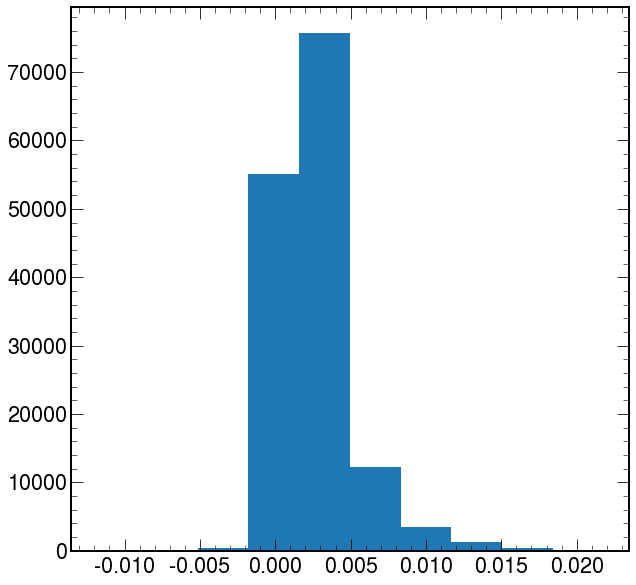

In [294]:
#plt.hist(dfs_pair["D"].eval("drap-drap_corr"))

Text(0, 1, '$\\Phi_p$')

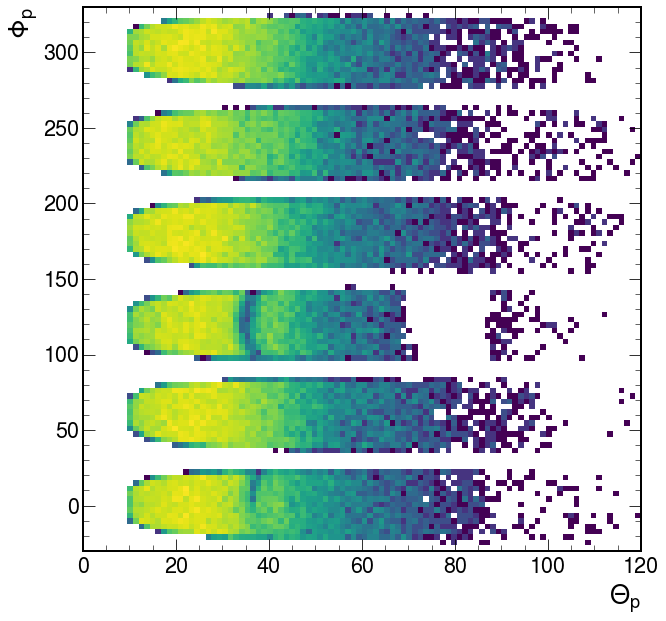

In [507]:
q = f"h1_pid==211   and h1_cm_pt > {pT1min} and "+\
                 f"h2_cm_pt_corr > {pT2min} and h1_z>0.5 and h2_pid==2212 and h2_p_corr>{pMin} and pass_proton_TOF_cut"

plt.hist2d(dfs_pair["D"].query(q).eval("h2_th"),dfs_pair["D"].query(q).eval("h2_ph"), bins=100, range=((0, 120),(-30, 330)), norm=mpl.colors.LogNorm())
plt.xlabel("$\\Theta_p$")
plt.ylabel("$\\Phi_p$")

In [341]:
max(dfs_pair["D"].eval("e_th"))*180/np.pi

50.0414332407639

In [ ]:
#proton cutflow:
df = dfs_pair["D"]